<a href="https://colab.research.google.com/github/TAUforPython/BioMedAI/blob/dev/GNN%20ECG%20timeseries%20prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# GNN with ECG downsampled signal, edge weight is a SMETS semilarity via ECG leads

# Load libraries

In [1]:
# GraphECGNet with PTB-XL Dataset in Google Colab
!pip install torch torchvision torchaudio --quiet
!pip install torch-geometric --quiet
!pip install wfdb --quiet

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 63.1/63.1 kB 1.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.1/1.1 MB 13.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 91.2/91.2 kB 2.1 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 163.8/163.8 kB 4.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.0/12.0 MB 88.0 MB/s eta 0:00:00
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
google-colab 1.0.0 requires pandas==2.2.2, but you have pandas 2.3.2 which is incompatible.
dask-cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.
cudf-cu12 25.6.0 requires pandas<2.2.4dev0,>=2.0, but you have pandas 2.3.2 which is incompatible.


In [2]:
import os
import ast
import pickle
import joblib
import shutil
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch_geometric.nn import GCNConv, global_mean_pool
from torch_geometric.data import Data
from torch_geometric.loader import DataLoader
import pandas as pd
import numpy as np
import wfdb
from sklearn.preprocessing import MultiLabelBinarizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, classification_report, confusion_matrix
from tqdm.auto import tqdm
import matplotlib.pyplot as plt
import seaborn as sns
import networkx as nx
from torch_geometric.data import Data

Rationale:

Physiological Meaning: Each ECG lead captures electrical activity from a different angle/view of the heart
Spatial Information: Different leads provide complementary information about heart activity
Feature Richness: Each node contains a time series of the ECG signal from that specific lead
Anatomical Relevance: Leads are positioned anatomically around the heart

Limb Lead Connections (0-5):

I ↔ II ↔ III: These leads form Einthoven's triangle
aVR, aVL, aVF: Augmented limb leads connected to the main limb leads
Adjacent leads share similar electrical pathways


Precordial Lead Connections (6-11):

V1 → V2 → V3 → V4 → V5 → V6: Anatomically sequential across the chest
Circular connection (V6 → V1): Completes the chest loop
Sequential activation: Electrical wavefront moves across the chest

# Load dataset

Dataset link:
https://physionet.org/content/ptb-xl/1.0.3/


Based on the PhysioNet dataset structure and the code, here's what information is used and for what purposes:




## 1. **ptbxl_database.csv** - Main Database File
```python
Y = pd.read_csv(path+'ptbxl_database.csv', index_col='ecg_id')
```
**Information contained:**
- **Patient demographics**: age, sex, weight, height
- **ECG metadata**: heart axis, infarction stadium
- **Clinical annotations**: scp_codes (SCP-ECG standard statements)
- **File references**: filename_lr, filename_hr (for raw data access)
- **Unique identifiers**: ecg_id, patient_id

**Used for:**
- Loading ECG file paths and metadata
- Extracting diagnostic labels for classification
- Patient stratification and analysis
- Quality control and validation information



## 2. **scp_statements.csv** - Standardized ECG Statements
```python
aggregation_df = pd.read_csv(folder+'scp_statements.csv', index_col=0)
```
**Information contained:**
- **71 different ECG statements** following SCP-ECG standard
- **Classification categories**: diagnostic, form, rhythm statements
- **Hierarchical organization**: diagnostic_class, diagnostic_subclass
- **Statement properties**: likelihood, priority, category

**Used for:**
- Converting raw SCP codes to meaningful diagnostic categories
- Creating superdiagnostic labels (aggregating similar conditions)
- Ensuring standardized interpretation across cardiologists
- Building consistent classification targets



## 3. **Raw ECG Signal Files** (.dat/.hea)
```python
data = [wfdb.rdsamp(path+f) for f in tqdm(df.filename_lr)]
```
**Information contained:**
- **12-lead ECG signals**: I, II, III, aVR, aVL, aVF, V1-V6
- **10-second recordings** at 100Hz or 500Hz sampling rate
- **Standardized format**: WFDB-compatible files

**Used for:**
- **Primary input data** for the GraphECGNet model
- Creating graph node features (each lead becomes a node)
- Training the neural network to recognize patterns
- Converting to graph representations where leads are nodes

In [3]:
# Download procedure with progress bar
from google.colab import drive
from tqdm import tqdm
import subprocess
import time

TOTAL_SAMPLES = 700


# Mount Google Drive
drive.mount('/content/drive')

# Define paths
DRIVE_PATH = '/content/drive/MyDrive/ptb_xl_200_samples'
LOCAL_PATH = '/content/ptb_xl_200_samples'

# Check if dataset already exists in Google Drive
if os.path.exists(DRIVE_PATH):
    print("✅ PTB-XL dataset already exists in Google Drive!")
    print("Skipping download...")
    # Create symlink or copy to local directory
    if not os.path.exists(LOCAL_PATH):
        !ln -s "{DRIVE_PATH}" "{LOCAL_PATH}"
    PATH = LOCAL_PATH
else:
    print("Dataset not found in Google Drive. Downloading first samples...")
    print("Progress: Downloading metadata files...")

    # Create directory
    !mkdir -p "{DRIVE_PATH}"
    %cd "{DRIVE_PATH}"

    # Download essential metadata files with progress indication
    print("1️⃣ Downloading ptbxl_database.csv...")
    !wget -N --progress=bar:force:noscroll https://physionet.org/files/ptb-xl/1.0.3/ptbxl_database.csv

    print("2️⃣ Downloading scp_statements.csv...")
    !wget -N --progress=bar:force:noscroll https://physionet.org/files/ptb-xl/1.0.3/scp_statements.csv

    # Create directory structure for first 200 samples
    !mkdir -p records100/00000

    print("3️⃣ Downloading first ECG samples...")
    print("🔄 This may take a few minutes. Please wait...")

    # Download first 200 ECG samples with progress bar
    failed_downloads = 0
    successful_downloads = 0

    # Create progress bar
    pbar = tqdm(range(1, TOTAL_SAMPLES+1), desc="Downloading ECG samples", unit="files")

    for i in pbar:
        # Format the filename with leading zeros
        filename = f"{i:05d}"
        folder = f"{(i//1000)*1000:05d}"

        # Create folder if it doesn't exist
        folder_path = f"records100/{folder}"
        if not os.path.exists(folder_path):
            os.makedirs(folder_path)

        # Download .dat and .hea files
        dat_url = f"https://physionet.org/files/ptb-xl/1.0.3/records100/{folder}/{filename}_lr.dat"
        hea_url = f"https://physionet.org/files/ptb-xl/1.0.3/records100/{folder}/{filename}_lr.hea"

        try:
            # Download files with error handling
            result_dat = subprocess.run(["wget", "-N", "-q", dat_url, "-P", folder_path],
                                      capture_output=True, text=True, timeout=30)
            result_hea = subprocess.run(["wget", "-N", "-q", hea_url, "-P", folder_path],
                                      capture_output=True, text=True, timeout=30)

            if result_dat.returncode == 0 and result_hea.returncode == 0:
                successful_downloads += 1
            else:
                failed_downloads += 1

        except subprocess.TimeoutExpired:
            failed_downloads += 1
            pbar.set_postfix({"Success": successful_downloads, "Failed": failed_downloads})
            continue
        except Exception as e:
            failed_downloads += 1
            pbar.set_postfix({"Success": successful_downloads, "Failed": failed_downloads})
            continue

        # Update progress bar
        pbar.set_postfix({"Success": successful_downloads, "Failed": failed_downloads})

        # Small delay to avoid overwhelming the server
        if i % 10 == 0:
            time.sleep(0.1)

    pbar.close()

    print(f"\n✅ Download completed!")
    print(f"   Successfully downloaded: {successful_downloads} samples")
    print(f"   Failed downloads: {failed_downloads} samples")

    if failed_downloads > 0:
        print("Some files failed to download. You may want to retry or check your connection.")

    print("Successfully downloaded first 200 ECG samples to Google Drive!")
    PATH = DRIVE_PATH

# Set working directory
%cd "{PATH}"
print(f"Working directory set to: {PATH}")
print("✅ Ready to process PTB-XL dataset!")

Mounted at /content/drive
✅ PTB-XL dataset already exists in Google Drive!
Skipping download...
/content/drive/MyDrive/ptb_xl_200_samples
Working directory set to: /content/ptb_xl_200_samples
✅ Ready to process PTB-XL dataset!


PTB-XL ECG Timeseries Visualization

1. Full 10-second ECG timeseries:


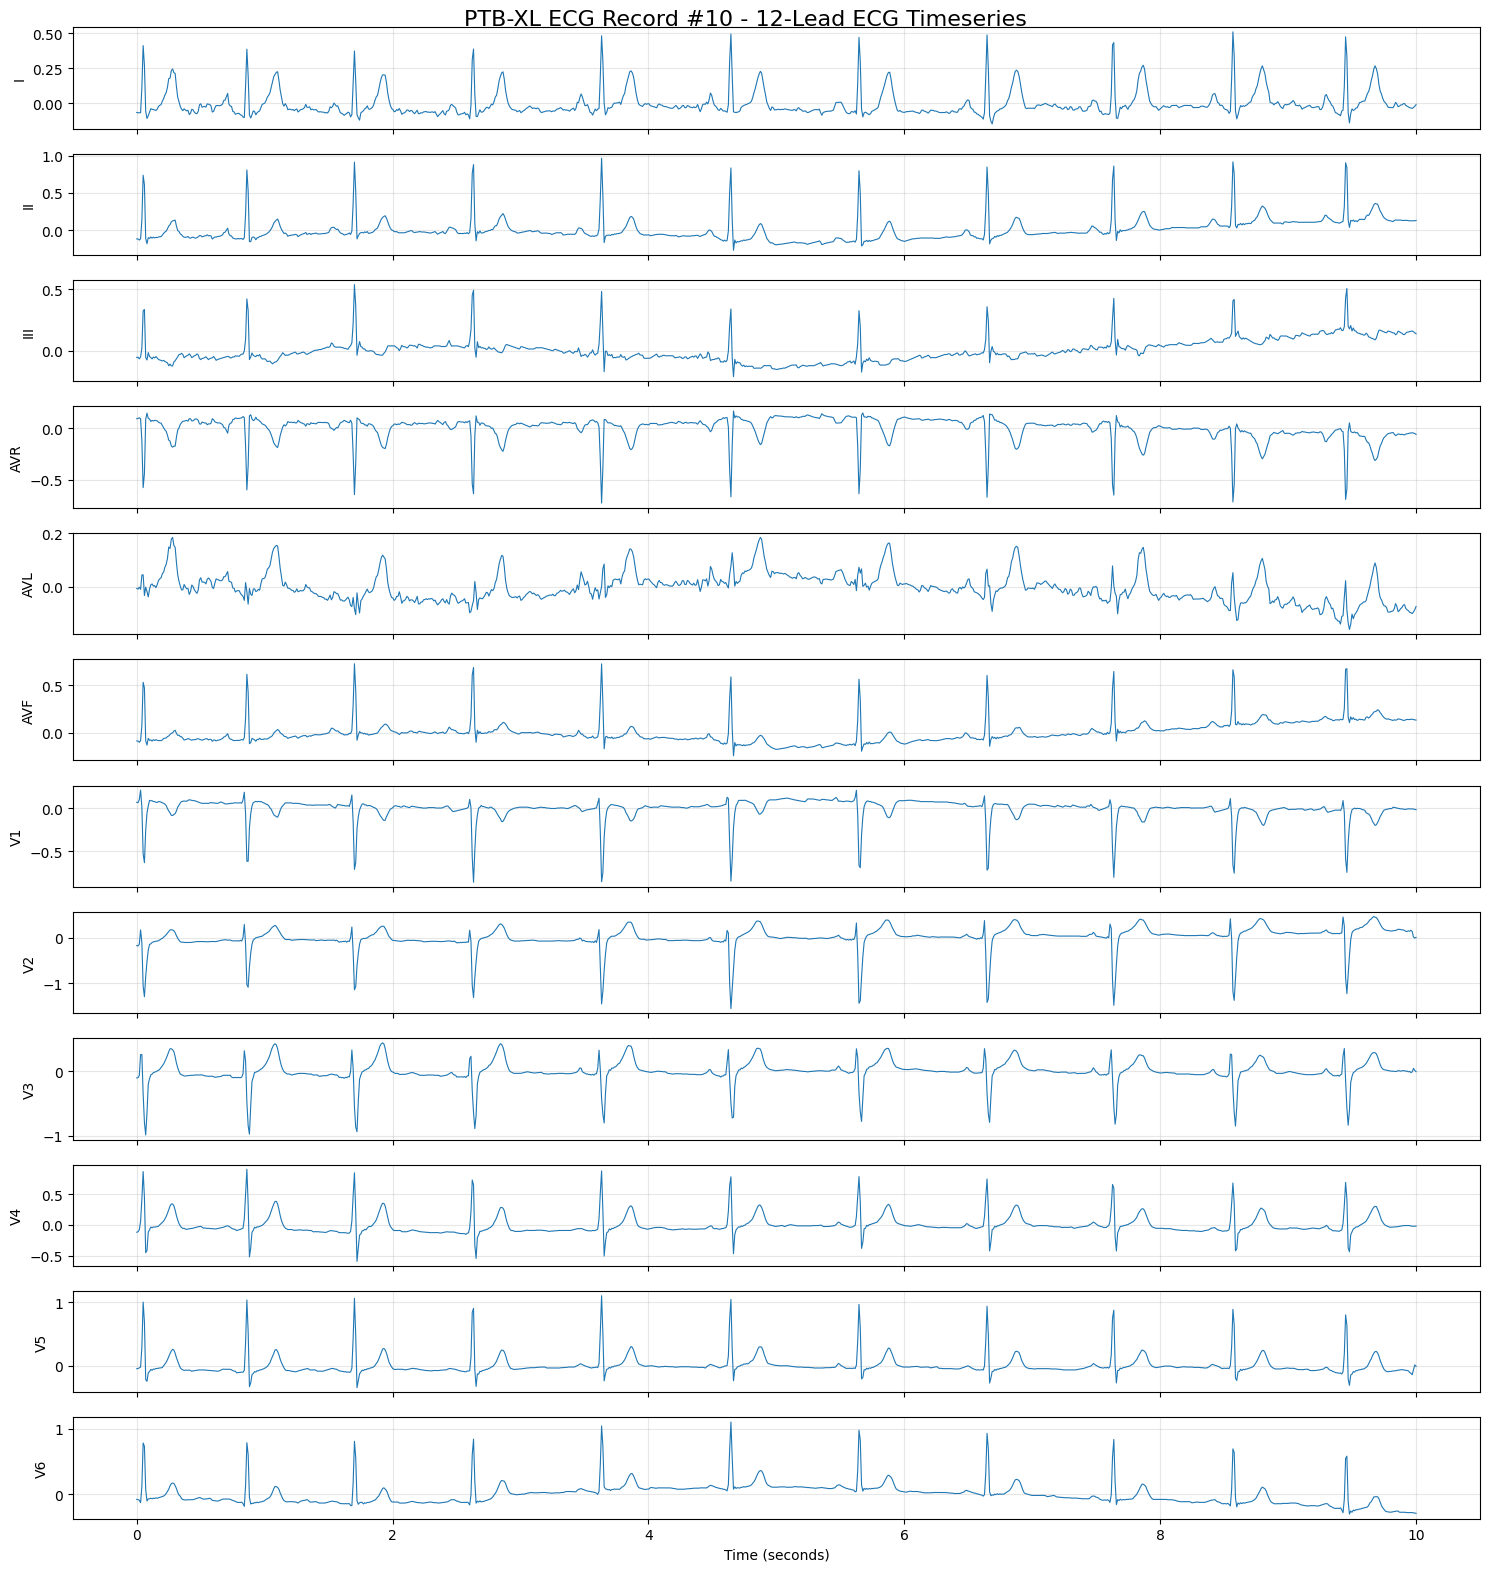

ECG Record #10 Information:
Sampling Rate: 100 Hz
Duration: 10.0 seconds
Number of Leads: 12
Lead Names: ['I', 'II', 'III', 'AVR', 'AVL', 'AVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
Signal Shape: (1000, 12)
Amplitude Range: [-1.552, 1.101]

2. Lead comparison (I, II, V1):


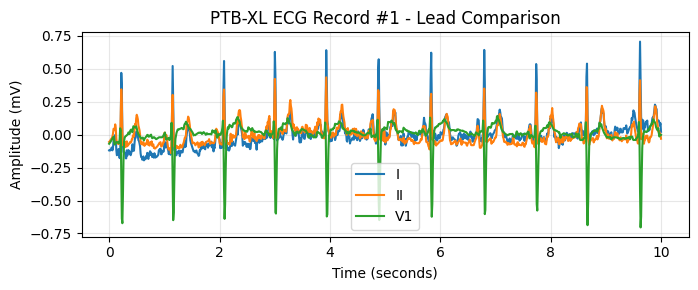


3. Detailed segment view (0-2 seconds):


/tmp/ipython-input-2294114614.py:170: UserWarning: Tight layout not applied. tight_layout cannot make Axes height small enough to accommodate all Axes decorations.
  plt.tight_layout()


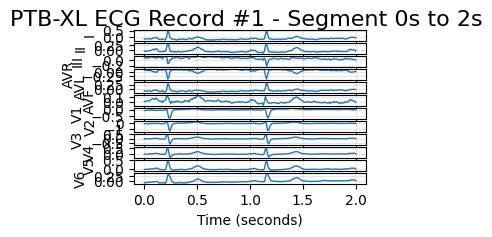

ECG Segment Information:
Record ID: 1
Time Segment: 0s to 2s
Samples: 200
Duration: 2 seconds


In [4]:
#plot ECG timeseries
import wfdb

def plot_ecg_timeseries(ecg_id=1, sampling_rate=100, base_path='/content/drive/MyDrive/ptb_xl_200_samples'):
    """
    Plot simple timeseries of downloaded ECG signal from PTB-XL dataset

    Parameters:
    ecg_id: ID of the ECG record to plot (1-200 for downloaded samples)
    sampling_rate: 100 for low resolution, 500 for high resolution
    base_path: path to the downloaded PTB-XL dataset
    """

    try:
        # Format the filename with leading zeros
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"

        # Determine file path based on sampling rate
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        # Read the ECG record
        record = wfdb.rdsamp(record_path)
        signals = record[0]  # Signal data
        metadata = record[1]  # Metadata

        # Get lead names
        lead_names = metadata['sig_name']

        # Plot all 12 leads
        fig, axes = plt.subplots(12, 1, figsize=(15, 16))
        fig.suptitle(f'PTB-XL ECG Record #{ecg_id} - 12-Lead ECG Timeseries', fontsize=16)

        time_points = np.linspace(0, signals.shape[0]/sampling_rate, signals.shape[0])

        for i in range(12):  # 12 leads
            axes[i].plot(time_points, signals[:, i], linewidth=0.8)
            axes[i].set_ylabel(lead_names[i] if i < len(lead_names) else f'Lead {i}')
            axes[i].grid(True, alpha=0.3)
            if i < 11:  # Hide x-label for all except bottom plot
                axes[i].set_xticklabels([])

        axes[11].set_xlabel('Time (seconds)')
        plt.tight_layout()
        plt.show()

        # Print metadata information
        print(f"ECG Record #{ecg_id} Information:")
        print(f"Sampling Rate: {sampling_rate} Hz")
        print(f"Duration: {signals.shape[0]/sampling_rate} seconds")
        print(f"Number of Leads: {signals.shape[1]}")
        print(f"Lead Names: {lead_names}")
        print(f"Signal Shape: {signals.shape}")
        print(f"Amplitude Range: [{np.min(signals):.3f}, {np.max(signals):.3f}]")

        return signals, metadata

    except Exception as e:
        print(f"Error loading ECG record #{ecg_id}: {e}")
        print("Make sure the record exists in your downloaded dataset.")
        return None, None

def plot_single_lead_comparison(ecg_id=1, lead_indices=[0, 1, 6], sampling_rate=100, base_path='/content/ptb_xl_200_samples'):
    """
    Plot comparison of specific leads from an ECG record

    Parameters:
    ecg_id: ID of the ECG record to plot
    lead_indices: List of lead indices to plot (0=I, 1=II, 6=V1, etc.)
    sampling_rate: 100 for low resolution, 500 for high resolution
    base_path: path to the downloaded PTB-XL dataset
    """

    try:
        # Format the filename
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"

        # Determine file path based on sampling rate
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        # Read the ECG record
        record = wfdb.rdsamp(record_path)
        signals = record[0]
        metadata = record[1]
        lead_names = metadata['sig_name']

        # Plot selected leads
        plt.figure(figsize=(7, 3))
        time_points = np.linspace(0, signals.shape[0]/sampling_rate, signals.shape[0])

        for i, lead_idx in enumerate(lead_indices):
            if lead_idx < signals.shape[1]:
                plt.plot(time_points, signals[:, lead_idx],
                        linewidth=1.5, label=lead_names[lead_idx] if lead_idx < len(lead_names) else f'Lead {lead_idx}')

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        plt.title(f'PTB-XL ECG Record #{ecg_id} - Lead Comparison')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        return signals, metadata

    except Exception as e:
        print(f"Error loading ECG record #{ecg_id}: {e}")
        return None, None

def plot_ecg_segment(ecg_id=1, start_time=0, duration=2, sampling_rate=100, base_path='/content/ptb_xl_200_samples'):
    """
    Plot a segment of ECG signal with detailed view

    Parameters:
    ecg_id: ID of the ECG record to plot
    start_time: Start time in seconds
    duration: Duration to plot in seconds
    sampling_rate: 100 for low resolution, 500 for high resolution
    base_path: path to the downloaded PTB-XL dataset
    """

    try:
        # Format the filename
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"

        # Determine file path based on sampling rate
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        # Read the ECG record
        record = wfdb.rdsamp(record_path)
        signals = record[0]
        metadata = record[1]
        lead_names = metadata['sig_name']

        # Calculate sample indices
        start_sample = int(start_time * sampling_rate)
        end_sample = int((start_time + duration) * sampling_rate)

        # Ensure we don't go beyond signal length
        end_sample = min(end_sample, signals.shape[0])
        start_sample = max(0, start_sample)

        # Extract segment
        segment_signals = signals[start_sample:end_sample, :]
        time_points = np.linspace(start_time, start_time + (end_sample-start_sample)/sampling_rate, segment_signals.shape[0])

        # Plot all 12 leads for the segment
        fig, axes = plt.subplots(12, 1, figsize=(3, 2))
        fig.suptitle(f'PTB-XL ECG Record #{ecg_id} - Segment {start_time}s to {start_time+duration}s', fontsize=16)

        for i in range(12):
            axes[i].plot(time_points, segment_signals[:, i], linewidth=1.0)
            axes[i].set_ylabel(lead_names[i] if i < len(lead_names) else f'Lead {i}')
            axes[i].grid(True, alpha=0.3)
            if i < 11:
                axes[i].set_xticklabels([])

        axes[11].set_xlabel('Time (seconds)')
        plt.tight_layout()
        plt.show()

        print(f"ECG Segment Information:")
        print(f"Record ID: {ecg_id}")
        print(f"Time Segment: {start_time}s to {start_time+duration}s")
        print(f"Samples: {segment_signals.shape[0]}")
        print(f"Duration: {duration} seconds")

        return segment_signals, metadata

    except Exception as e:
        print(f"Error loading ECG record #{ecg_id}: {e}")
        return None, None

# Usage examples:
print("PTB-XL ECG Timeseries Visualization")
print("="*40)

# Plot full 10-second ECG for record #1
print("\n1. Full 10-second ECG timeseries:")
signals, metadata = plot_ecg_timeseries(ecg_id=10, sampling_rate=100)

# Plot comparison of specific leads
print("\n2. Lead comparison (I, II, V1):")
plot_single_lead_comparison(ecg_id=1, lead_indices=[0, 1, 6], sampling_rate=100)

# Plot a 2-second segment with more detail
print("\n3. Detailed segment view (0-2 seconds):")
segment_signals, segment_metadata = plot_ecg_segment(ecg_id=1, start_time=0, duration=2, sampling_rate=100)

In [23]:

# DATA LOADING FUNCTIONS
def select_data(XX, YY, outputfolder):
    """
    Select data with valid labels
    Handles mismatch between signals and metadata
    """
    # First, ensure we have matching lengths
    min_length = min(len(XX), len(YY))
    XX_matched = XX[:min_length] if len(XX) > min_length else XX
    YY_matched = YY.iloc[:min_length] if len(YY) > min_length else YY

    # Filter for records with superdiagnostic labels
    valid_mask = YY_matched.superdiagnostic_len > 0
    X = XX_matched[valid_mask]
    Y = YY_matched[valid_mask]

    # Apply MultiLabelBinarizer
    mlb = MultiLabelBinarizer()
    mlb.fit(Y.superdiagnostic.values)
    y = mlb.transform(Y.superdiagnostic.values)

    # Save LabelBinarizer
    with open(outputfolder+'mlb.pkl', 'wb') as tokenizer:
        pickle.dump(mlb, tokenizer)

    return X, Y, y, mlb


def load_raw_data_ptbxl(df, sampling_rate, path, max_samples=TOTAL_SAMPLES):
    """
    Load raw ECG data from PTB-XL dataset

    Parameters:
    df: DataFrame with filename information
    sampling_rate: 100 or 500 Hz
    path: base path to dataset
    max_samples: maximum number of samples to load
    """
    try:
        if sampling_rate == 100:
            # Limit to available samples and handle missing files
            available_files = []
            filenames = df.filename_lr.iloc[:max_samples] if len(df.filename_lr) >= max_samples else df.filename_lr

            for f in tqdm(filenames, desc="Loading ECG files"):
                file_path = path + f
                # Check if file exists before trying to load
                if os.path.exists(file_path + '.hea') and os.path.exists(file_path + '.dat'):
                    available_files.append(f)
                else:
                    print(f"Warning: File not found - {file_path}")

            print(f"Loading {len(available_files)} available ECG files...")
            data = []
            for f in tqdm(available_files, desc="Reading files"):
                try:
                    signal, meta = wfdb.rdsamp(path + f)
                    data.append((signal, meta))
                except Exception as e:
                    print(f"Error loading {f}: {e}")
                    continue

            # Extract signals only
            signals = np.array([signal for signal, meta in data])

        elif sampling_rate == 500:
            # Same for high resolution files
            available_files = []
            filenames = df.filename_hr.iloc[:max_samples] if len(df.filename_hr) >= max_samples else df.filename_hr

            for f in tqdm(filenames, desc="Loading ECG files"):
                file_path = path + f
                if os.path.exists(file_path + '.hea') and os.path.exists(file_path + '.dat'):
                    available_files.append(f)
                else:
                    print(f"Warning: File not found - {file_path}")

            print(f"Loading {len(available_files)} available ECG files...")
            data = []
            for f in tqdm(available_files, desc="Reading files"):
                try:
                    signal, meta = wfdb.rdsamp(path + f)
                    data.append((signal, meta))
                except Exception as e:
                    print(f"Error loading {f}: {e}")
                    continue

            signals = np.array([signal for signal, meta in data])

        return signals

    except Exception as e:
        print(f"Error in load_raw_data_ptbxl: {e}")
        return np.array([])

def load_dataset(path, sampling_rate, max_samples=200):
    """
    Load PTB-XL dataset

    Parameters:
    path: base path to dataset
    sampling_rate: 100 or 500 Hz
    max_samples: maximum number of samples to load
    """
    try:
        # Load database metadata
        print("Loading database metadata...")
        database_path = os.path.join(path, 'ptbxl_database.csv')
        if not os.path.exists(database_path):
            raise FileNotFoundError(f"Database file not found: {database_path}")

        Y = pd.read_csv(database_path, index_col='ecg_id')
        Y.scp_codes = Y.scp_codes.apply(lambda x: ast.literal_eval(x))

        # Limit to available samples (first max_samples)
        Y = Y.iloc[:max_samples]

        print(f"Loading {len(Y)} ECG records...")
        X = load_raw_data_ptbxl(Y, sampling_rate, path, max_samples)

        return X, Y

    except Exception as e:
        print(f"Error loading dataset: {e}")
        print("Available files in directory:")
        try:
            for root, dirs, files in os.walk(path):
                level = root.replace(path, '').count(os.sep)
                indent = ' ' * 2 * level
                print(f"{indent}{os.path.basename(root)}/")
                subindent = ' ' * 2 * (level + 1)
                if level < 3:  # Only show top levels to avoid clutter
                    for file in files[:5]:  # Show first 5 files
                        print(f"{subindent}{file}")
                    if len(files) > 5:
                        print(f"{subindent}... and {len(files)-5} more files")
        except:
            pass
        return None, None



def compute_label_aggregations(df, folder, ctype):
    """
    Compute label aggregations with proper error handling
    """
    try:
        df['scp_codes_len'] = df.scp_codes.apply(lambda x: len(x))
        aggregation_df = pd.read_csv(folder+'scp_statements.csv', index_col=0)
    except Exception as e:
        print(f"Error reading scp_statements.csv: {e}")
        return df.reset_index(drop=True)

    # Rest of the function remains the same...
    if ctype in ['diagnostic', 'subdiagnostic', 'superdiagnostic']:
        def aggregate_all_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    tmp.append(key)
            return list(set(tmp))

        def aggregate_subdiagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    c = diag_agg_df.loc[key].diagnostic_subclass
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        def aggregate_diagnostic(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in diag_agg_df.index:
                    c = diag_agg_df.loc[key].diagnostic_class
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        diag_agg_df = aggregation_df[aggregation_df.diagnostic == 1.0]
        if ctype == 'diagnostic':
            df['diagnostic'] = df.scp_codes.apply(aggregate_all_diagnostic)
            df['diagnostic_len'] = df.diagnostic.apply(lambda x: len(x))
        elif ctype == 'subdiagnostic':
            df['subdiagnostic'] = df.scp_codes.apply(aggregate_subdiagnostic)
            df['subdiagnostic_len'] = df.subdiagnostic.apply(lambda x: len(x))
        elif ctype == 'superdiagnostic':
            df['superdiagnostic'] = df.scp_codes.apply(aggregate_diagnostic)
            df['superdiagnostic_len'] = df.superdiagnostic.apply(lambda x: len(x))
    elif ctype == 'form':
        form_agg_df = aggregation_df[aggregation_df.form == 1.0]

        def aggregate_form(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in form_agg_df.index:
                    c = key
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        df['form'] = df.scp_codes.apply(aggregate_form)
        df['form_len'] = df.form.apply(lambda x: len(x))
    elif ctype == 'rhythm':
        rhythm_agg_df = aggregation_df[aggregation_df.rhythm == 1.0]

        def aggregate_rhythm(y_dic):
            tmp = []
            for key in y_dic.keys():
                if key in rhythm_agg_df.index:
                    c = key
                    if str(c) != 'nan':
                        tmp.append(c)
            return list(set(tmp))

        df['rhythm'] = df.scp_codes.apply(aggregate_rhythm)
        df['rhythm_len'] = df.rhythm.apply(lambda x: len(x))
    elif ctype == 'all':
        df['all_scp'] = df.scp_codes.apply(lambda x: list(set(x.keys())))

    return df.reset_index(drop=True)

# GRAPH ECG NETWORK
class GraphECGNet(nn.Module):
    def __init__(self, num_features, hidden_dim=32, num_classes=5):  # Reduced hidden_dim
        super(GraphECGNet, self).__init__()
        self.conv1 = GCNConv(num_features, hidden_dim)
        self.conv2 = GCNConv(hidden_dim, hidden_dim * 2)
        self.conv3 = GCNConv(hidden_dim * 2, hidden_dim)
        self.fc1 = nn.Linear(hidden_dim, 16)  # Reduced hidden layer size
        self.fc2 = nn.Linear(16, num_classes)
        self.dropout = nn.Dropout(0.3)  # Increased dropout

    def forward(self, data):
        x, edge_index, batch = data.x, data.edge_index, data.batch
        edge_attr = data.edge_attr if hasattr(data, 'edge_attr') and data.edge_attr is not None else None

        # Graph convolutions with edge weights
        x = F.relu(self.conv1(x, edge_index, edge_weight=edge_attr))
        x = F.dropout(x, training=self.training, p=0.3)  # Higher dropout
        x = F.relu(self.conv2(x, edge_index, edge_weight=edge_attr))
        x = F.dropout(x, training=self.training, p=0.3)
        x = F.relu(self.conv3(x, edge_index, edge_weight=edge_attr))
        x = F.dropout(x, training=self.training, p=0.3)

        # Global pooling
        x = global_mean_pool(x, batch)

        # Classification layers
        x = F.relu(self.fc1(x))
        x = self.dropout(x)
        x = self.fc2(x)

        return F.log_softmax(x, dim=1)

# CREATE GRAPH REPRESENTATION FROM ECG SIGNALS
import torch
from torch_geometric.data import Data
import numpy as np
from scipy.spatial.distance import euclidean
from scipy.stats import pearsonr

def calculate_smets_distance(series1, series2, window_size=50):
    """
    Calculate SMETS distance between two time series
    Optimized for longer signals from PTB-XL dataset

    Parameters:
    series1, series2: 1D numpy arrays (time series)
    window_size: size of sliding window for shape comparison

    Returns:
    distance: SMETS distance value
    """
    # Ensure series have same length
    min_len = min(len(series1), len(series2))
    series1 = series1[:min_len]
    series2 = series2[:min_len]

    # For PTB-XL signals (5000 samples at 100Hz), use larger window
    if min_len > 1000:
        window_size = 100  # Larger window for longer signals

    if min_len < window_size:
        window_size = max(1, min_len // 2)

    # Normalize series to [0,1]
    def normalize(series):
        min_val = np.min(series)
        max_val = np.max(series)
        if max_val > min_val:
            return (series - min_val) / (max_val - min_val)
        return series

    series1_norm = normalize(series1)
    series2_norm = normalize(series2)

    # Calculate shape-based distance using sliding windows
    distances = []
    # Use larger step size for efficiency with long signals
    step_size = max(1, window_size // 4)

    for i in range(0, min_len - window_size + 1, step_size):
        window1 = series1_norm[i:i + window_size]
        window2 = series2_norm[i:i + window_size]

        # Euclidean distance between normalized windows
        dist = euclidean(window1, window2)
        distances.append(dist)

    # Return average distance (lower = more similar)
    if distances:
        return np.mean(distances)
    else:
        return abs(np.mean(series1_norm) - np.mean(series2_norm))

def calculate_pearson_similarity(series1, series2):
    """
    Calculate Pearson correlation similarity between two time series
    """
    # Ensure same length
    min_len = min(len(series1), len(series2))
    series1 = series1[:min_len]
    series2 = series2[:min_len]

    if min_len < 2:
        return 0.0

    try:
        corr, _ = pearsonr(series1, series2)
        # Convert correlation to similarity (0 to 1 range)
        return (corr + 1) / 2  # 0 = no correlation, 1 = perfect correlation
    except:
        return 0.5  # Default similarity if calculation fails


def create_ecg_graph(signal_data, label):
    """
    Convert ECG signal to graph representation with edge weights based on SMETS
    Each lead becomes a node in the graph
    Edge weights are based on similarity between ECG leads using SMETS
    """
    # Ensure correct shape [leads, time_points]
    if signal_data.shape[0] != 12:  # If not 12 leads as first dimension
        signal_data = signal_data.T  # Transpose to [12, time_points]

    num_leads, seq_len = signal_data.shape

    # More reasonable downsampling - keep 250 features per lead (better balance)
    target_features = 250  # Increased from 100 but still manageable
    step = max(1, seq_len // target_features)
    downsampled_signals = signal_data[:, ::step][:, :target_features]

    # Node features: downsampled ECG signal values
    x = torch.tensor(downsampled_signals, dtype=torch.float)  # [num_leads, num_features]

    # Create adjacency matrix (physiological connections)
    edge_index = []
    edge_weights = []

    # Standard 12-lead ECG connections
    lead_connections = [
        (0, 1), (1, 2), (2, 3), (3, 4), (4, 5),  # Limb leads
        (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 6),  # Precordial leads
        (0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11)  # Cross connections
    ]

    # Calculate SMETS-based edge weights using downsampled signals for efficiency
    for i, j in lead_connections:
        if i < num_leads and j < num_leads:
            # Get the downsampled signals for both leads (more efficient for SMETS)
            lead_i_signal = downsampled_signals[i].numpy()
            lead_j_signal = downsampled_signals[j].numpy()

            # Calculate SMETS distance
            smets_distance = calculate_smets_distance(lead_i_signal, lead_j_signal)

            # Convert distance to similarity (higher similarity = lower distance)
            similarity = np.exp(-smets_distance)

            # Ensure minimum weight to avoid zero weights
            edge_weight = max(0.1, similarity)

            edge_weights.extend([edge_weight, edge_weight])  # Bidirectional
            edge_index.append([i, j])
            edge_index.append([j, i])

    # Add self-loops with higher weights (strong self-connection)
    for i in range(num_leads):
        edge_index.append([i, i])
        edge_weights.append(1.5)  # Stronger self-connection

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)

    # Create graph data object with edge attributes
    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    graph_data.y = torch.tensor(label, dtype=torch.long)

    return graph_data

def create_ecg_graph_enhanced(signal_data, label, target_features=250):
    """
    Enhanced version using both SMETS and Pearson correlation with full signals
    """
    # Ensure correct shape [leads, time_points]
    if signal_data.shape[0] != 12:
        signal_data = signal_data.T

    num_leads, seq_len = signal_data.shape


    step = max(1, seq_len // target_features)
    downsampled_signals = signal_data[:, ::step][:, :target_features]

    # Use full signal for node features (no downsampling)
    x = torch.tensor(downsampled_signals, dtype=torch.float)  # [num_leads, seq_len]

    # Create adjacency matrix
    edge_index = []
    edge_weights = []

    # Standard 12-lead ECG connections
    lead_connections = [
        (0, 1), (1, 2), (2, 3), (3, 4), (4, 5),  # Limb leads
        (6, 7), (7, 8), (8, 9), (9, 10), (10, 11), (11, 6),  # Precordial leads
        (0, 6), (1, 7), (2, 8), (3, 9), (4, 10), (5, 11)  # Cross connections
    ]

    # Calculate combined edge weights using SMETS and Pearson correlation with full signals
    for i, j in lead_connections:
        if i < num_leads and j < num_leads:
            # Get the full signals
            lead_i_signal = signal_data[i]  # Use full signal
            lead_j_signal = signal_data[j]  # Use full signal

            # Calculate SMETS distance
            smets_distance = calculate_smets_distance(lead_i_signal, lead_j_signal)
            smets_similarity = np.exp(-smets_distance)

            # Calculate Pearson correlation similarity
            pearson_sim = calculate_pearson_similarity(lead_i_signal, lead_j_signal)

            # Combine both similarities (weighted average)
            combined_similarity = 0.6 * smets_similarity + 0.4 * pearson_sim
            edge_weight = max(0.1, combined_similarity)

            edge_weights.extend([edge_weight, edge_weight])  # Bidirectional
            edge_index.append([i, j])
            edge_index.append([j, i])

    # Add self-loops
    for i in range(num_leads):
        edge_index.append([i, i])
        edge_weights.append(1.5)

    edge_index = torch.tensor(edge_index, dtype=torch.long).t().contiguous()
    edge_attr = torch.tensor(edge_weights, dtype=torch.float)

    # Create graph data object
    graph_data = Data(x=x, edge_index=edge_index, edge_attr=edge_attr)
    graph_data.y = torch.tensor(label, dtype=torch.long)

    return graph_data



# VISUALIZE GRAPH FUNCTION
def visualize_ecg_graph(graph_data, sample_idx=0):
    """Visualize ECG graph structure and signals with edge weights"""

    fig = plt.figure(figsize=(20, 15))

    # 1. Graph structure visualization with edge weights
    plt.subplot(2, 3, 1)
    G = nx.Graph()

    # Add nodes (ECG leads)
    lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']
    num_nodes = graph_data.x.shape[0]
    node_labels = {i: lead_names[i] if i < len(lead_names) else f'Lead {i}' for i in range(num_nodes)}

    G.add_nodes_from(range(num_nodes))

    # Add edges with weights
    edge_weights = []
    for i in range(graph_data.edge_index.shape[1]):
        src, dst = graph_data.edge_index[:, i].tolist()
        if src != dst:  # Skip self-loops for visualization
            G.add_edge(src, dst)
            # Get edge weight if available
            if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
                weight = graph_data.edge_attr[i].item()
                G[src][dst]['weight'] = weight
                edge_weights.append(weight)
            else:
                edge_weights.append(1.0)

    # Position nodes in a circular layout
    pos = nx.circular_layout(G)

    # Draw edges with widths based on weights
    if edge_weights:
        # Normalize weights for visualization (0.5 to 5.0 range)
        min_weight = min(edge_weights)
        max_weight = max(edge_weights)
        if max_weight > min_weight:
            normalized_widths = [0.5 + 4.5 * (w - min_weight) / (max_weight - min_weight) for w in edge_weights]
        else:
            normalized_widths = [2.0] * len(edge_weights)

        # Use a fixed color for edges to avoid RGBA error
        nx.draw_networkx_edges(G, pos, width=normalized_widths, edge_color='blue', alpha=0.6)
    else:
        nx.draw_networkx_edges(G, pos, edge_color='blue', alpha=0.6)

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color='lightblue', node_size=1000)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=8, font_weight='bold')

    plt.title('ECG Lead Graph Structure\n(Edge widths = weights)')
    plt.axis('off')

    # 2. Node features heatmap
    plt.subplot(2, 3, 2)
    sns.heatmap(graph_data.x.numpy(), cmap='RdYlBu', cbar=True)
    plt.title('Node Features (ECG Signal Segments)')
    plt.xlabel('Time Points')
    plt.ylabel('ECG Leads')

    # 3. Adjacency matrix
    plt.subplot(2, 3, 3)
    num_nodes = graph_data.x.shape[0]
    adj_matrix = np.zeros((num_nodes, num_nodes))
    for i in range(graph_data.edge_index.shape[1]):
        src, dst = graph_data.edge_index[:, i]
        adj_matrix[src, dst] = 1
    sns.heatmap(adj_matrix, cmap='Blues', cbar=True)
    plt.title('Adjacency Matrix')
    plt.xlabel('ECG Leads')
    plt.ylabel('ECG Leads')

    # 4. Sample ECG signals
    plt.subplot(2, 3, 4)
    if graph_data.x.shape[0] > 0:
        plt.plot(graph_data.x[0, :50].numpy(), label='Lead I', linewidth=2)
        if graph_data.x.shape[0] > 1:
            plt.plot(graph_data.x[1, :50].numpy(), label='Lead II', linewidth=2)
        plt.title('Sample ECG Signals (First 50 Points)')
        plt.xlabel('Time')
        plt.ylabel('Amplitude')
        plt.legend()

    # 5. All lead signals
    plt.subplot(2, 3, 5)
    for i in range(min(6, graph_data.x.shape[0])):  # Show first 6 leads
        plt.plot(graph_data.x[i, :30].numpy() + i*0.5, label=f'Lead {lead_names[i] if i < len(lead_names) else i}', alpha=0.7)
    plt.title('Multiple ECG Leads (Offset for Visualization)')
    plt.xlabel('Time')
    plt.ylabel('Amplitude + Offset')
    plt.legend()

    # 6. Edge weights visualization
    plt.subplot(2, 3, 6)
    if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
        # Plot histogram of edge weights
        weights = graph_data.edge_attr.numpy()
        plt.hist(weights, bins=20, alpha=0.7, color='green')
        plt.xlabel('Edge Weight')
        plt.ylabel('Frequency')
        plt.title(f'Edge Weight Distribution\nMean: {np.mean(weights):.3f}, Std: {np.std(weights):.3f}')
        plt.grid(True, alpha=0.3)
    else:
        # If no edge weights, show message
        plt.text(0.5, 0.5, 'No Edge Weights\nAvailable', ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=14)
        plt.title('Edge Weights')

    plt.tight_layout()
    plt.show()

    print(f"Graph Info:")
    print(f"- Number of nodes (leads): {graph_data.x.shape[0]}")
    print(f"- Number of node features: {graph_data.x.shape[1]}")
    print(f"- Number of edges: {graph_data.edge_index.shape[1]}")
    if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
        weights = graph_data.edge_attr.numpy()
        print(f"- Edge weights: min={np.min(weights):.3f}, max={np.max(weights):.3f}, mean={np.mean(weights):.3f}")
    print(f"- Label: {graph_data.y.item() if hasattr(graph_data, 'y') else 'N/A'}")

In [26]:
    # Set the path to the downloaded PTB-XL dataset
    PATH = '/content/drive/MyDrive/ptb_xl_200_samples/'

    # Load dataset with 100 Hz sampling rate
    X, Y = load_dataset(PATH, 100, max_samples=TOTAL_SAMPLES)

    if X is not None and Y is not None:
        print(f"Successfully loaded dataset:")
        print(f"  ECG signals shape: {X.shape}")
        print(f"  Metadata records: {len(Y)}")

        # Compute label aggregations for superdiagnostic classes
        print("Computing label aggregations...")
        Y = compute_label_aggregations(Y, PATH, 'superdiagnostic')

        # Create output directory
        OUTPUT_DIR = '/content/ptb_xl_output/'
        if not os.path.exists(OUTPUT_DIR):
            os.makedirs(OUTPUT_DIR)

        # Select data with valid labels - now with proper handling
        print("Selecting data with valid labels...")
        X_selected, Y_selected, y_labels, mlb = select_data(X, Y, OUTPUT_DIR)

        print(f"Selected data:")
        print(f"  ECG signals: {X_selected.shape}")
        print(f"  Metadata records: {len(Y_selected)}")
        print(f"  Labels shape: {y_labels.shape}")
        print(f"  Number of classes: {y_labels.shape[1]}")

    # Get class names
    class_names = mlb.classes_
    print(f"Loaded {len(X_selected)} ECG samples")
    print(f"Number of classes: {len(class_names)}")
    print(f"Classes: {class_names}")

    # Convert multi-label to single label (take first label for simplicity)
    y_single_labels = np.argmax(y_labels[:TOTAL_SAMPLES], axis=1)  # Use first 200 samples

Loading database metadata...
Loading 700 ECG records...


Loading ECG files: 100%|██████████| 700/700 [00:00<00:00, 2403.23it/s]


Loading 688 available ECG files...


Reading files: 100%|██████████| 688/688 [00:06<00:00, 99.49it/s]


Successfully loaded dataset:
  ECG signals shape: (688, 1000, 12)
  Metadata records: 700
Computing label aggregations...
Selecting data with valid labels...
Selected data:
  ECG signals: (677, 1000, 12)
  Metadata records: 677
  Labels shape: (677, 5)
  Number of classes: 5
Loaded 677 ECG samples
Number of classes: 5
Classes: ['CD' 'HYP' 'MI' 'NORM' 'STTC']


Plotting class distribution...


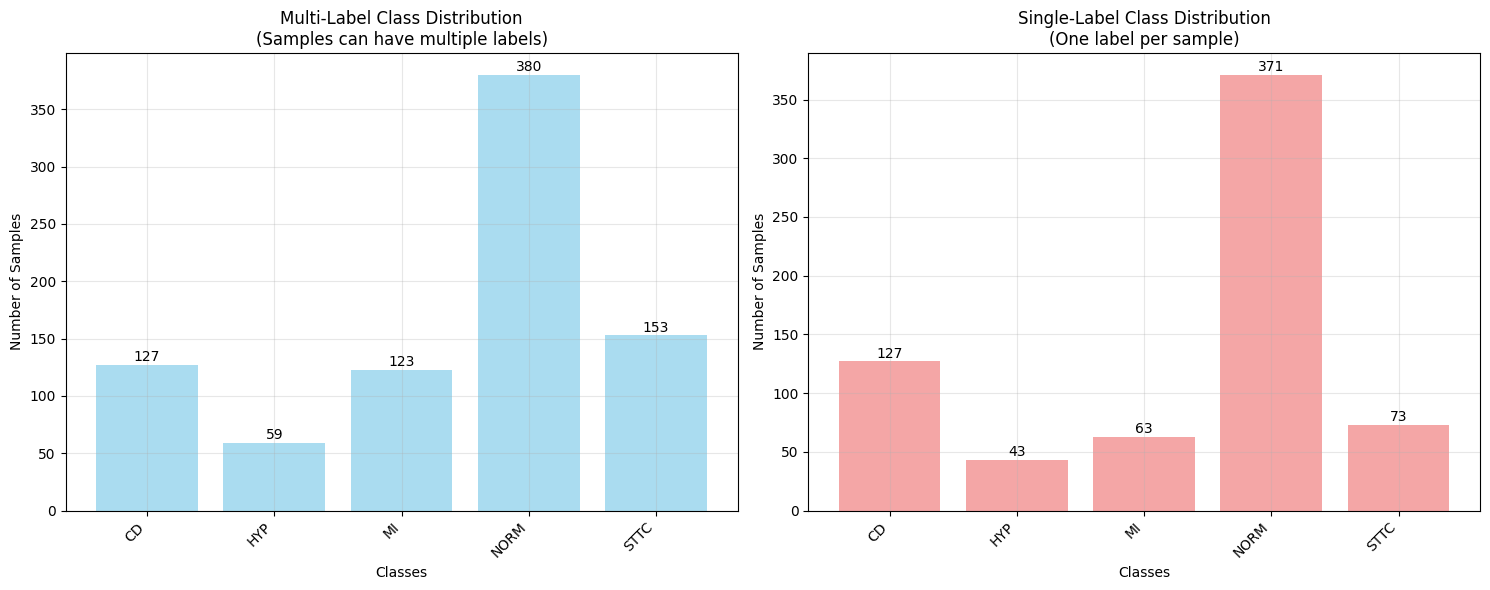

CLASS DISTRIBUTION STATISTICS
Total samples: 677
Number of classes: 5
Total labels (multi-label): 842
Average labels per sample: 1.24

Multi-label distribution:
  CD: 127 (18.8%)
  HYP: 59 (8.7%)
  MI: 123 (18.2%)
  NORM: 380 (56.1%)
  STTC: 153 (22.6%)

Single-label distribution:
  CD: 127 (18.8%)
  HYP: 43 (6.4%)
  MI: 63 (9.3%)
  NORM: 371 (54.8%)
  STTC: 73 (10.8%)


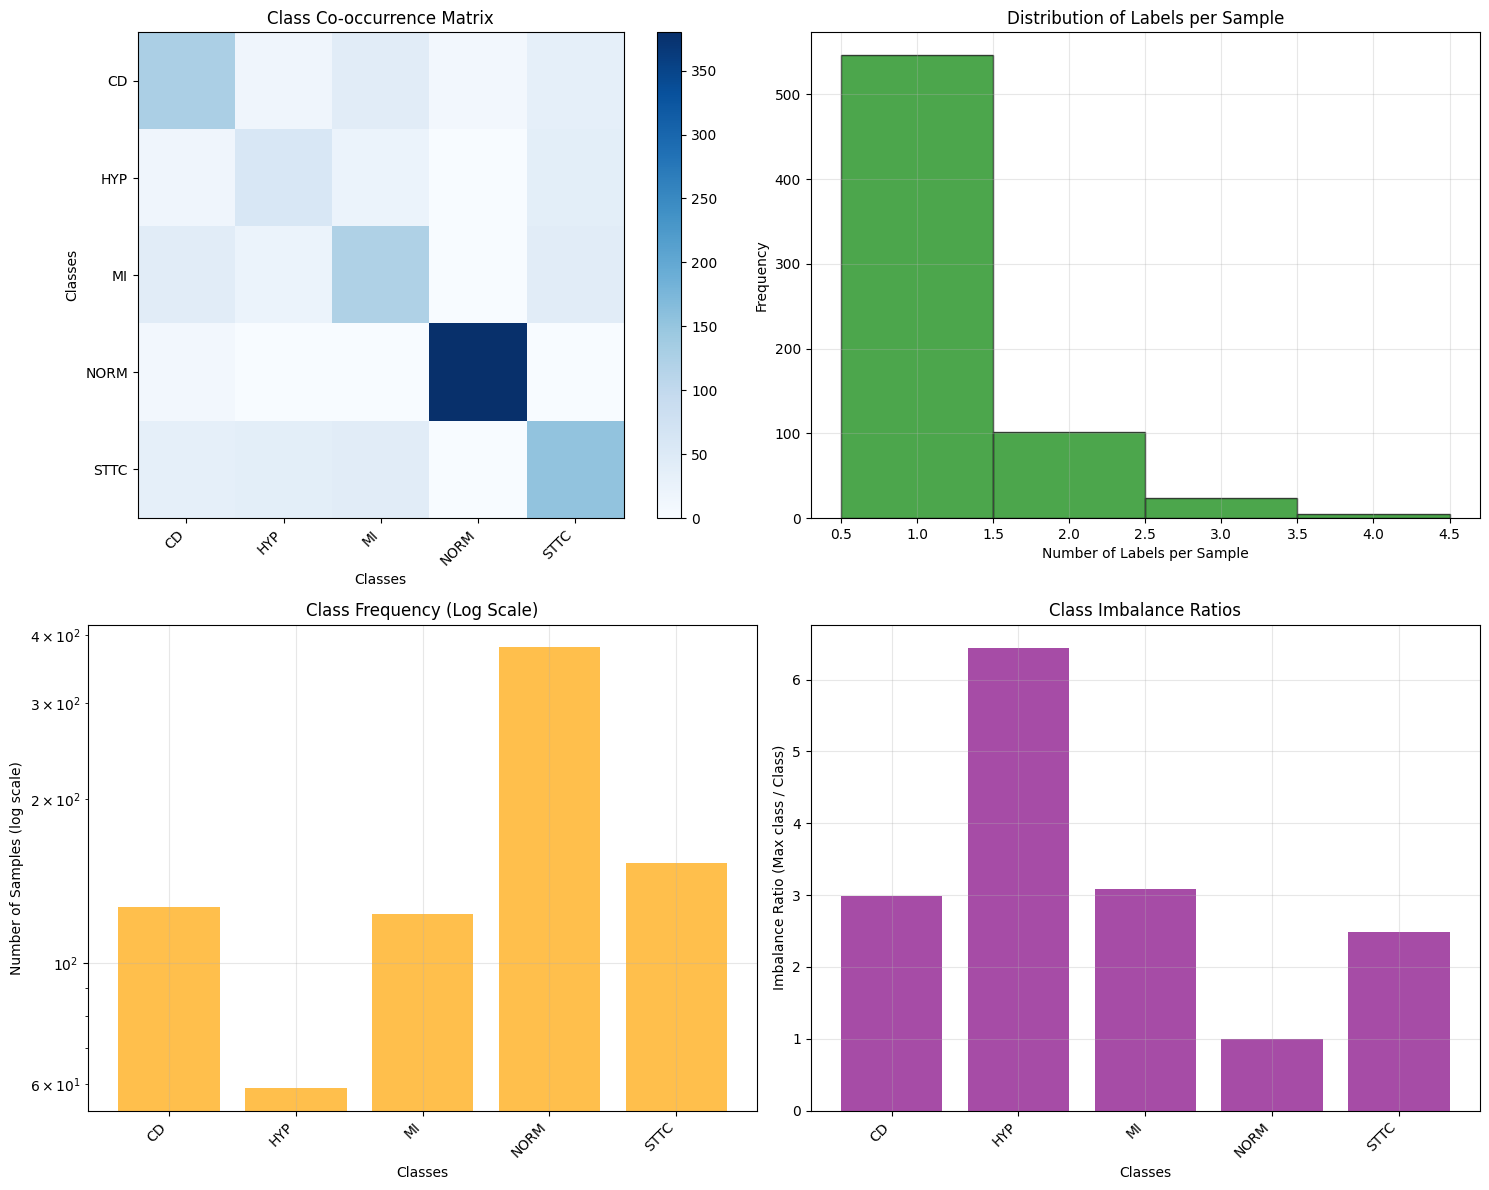


DETAILED CLASS ANALYSIS
Samples with no labels: 0
Samples with one label: 546
Samples with multiple labels: 131
Max labels per sample: 4
Most common co-occurrence pairs:
  CD + HYP: 16
  CD + MI: 42
  CD + NORM: 9
  CD + STTC: 34
  HYP + MI: 23
  HYP + STTC: 38
  MI + STTC: 42


In [28]:

# Assuming you've already loaded your data using the code you provided
# X_selected, Y_selected, y_labels, mlb, class_names, y_single_labels are already defined

def plot_class_distribution(y_labels, class_names, y_single_labels=None):
    """
    Plot class distribution for the PTB-XL dataset

    Parameters:
    y_labels: Multi-label binary matrix (samples x classes)
    class_names: List of class names
    y_single_labels: Single label indices (optional)
    """

    # Create figure with subplots
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # 1. Multi-label distribution
    class_counts_multi = np.sum(y_labels, axis=0)

    axes[0].bar(range(len(class_names)), class_counts_multi, color='skyblue', alpha=0.7)
    axes[0].set_xlabel('Classes')
    axes[0].set_ylabel('Number of Samples')
    axes[0].set_title('Multi-Label Class Distribution\n(Samples can have multiple labels)')
    axes[0].set_xticks(range(len(class_names)))
    axes[0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0].grid(True, alpha=0.3)

    # Add count labels on bars
    for i, count in enumerate(class_counts_multi):
        axes[0].text(i, count + 0.5, str(int(count)), ha='center', va='bottom')

    # 2. Single-label distribution (if provided)
    if y_single_labels is not None:
        unique, counts = np.unique(y_single_labels, return_counts=True)

        axes[1].bar(unique, counts, color='lightcoral', alpha=0.7)
        axes[1].set_xlabel('Classes')
        axes[1].set_ylabel('Number of Samples')
        axes[1].set_title('Single-Label Class Distribution\n(One label per sample)')
        axes[1].set_xticks(unique)
        axes[1].set_xticklabels([class_names[i] for i in unique], rotation=45, ha='right')
        axes[1].grid(True, alpha=0.3)

        # Add count labels on bars
        for i, count in zip(unique, counts):
            axes[1].text(i, count + 0.5, str(count), ha='center', va='bottom')
    else:
        axes[1].text(0.5, 0.5, 'Single-label distribution\nnot available',
                    ha='center', va='center', transform=axes[1].transAxes)
        axes[1].set_title('Single-Label Class Distribution')

    plt.tight_layout()
    plt.show()

    # Print statistics
    print("CLASS DISTRIBUTION STATISTICS")
    print("="*40)
    print(f"Total samples: {y_labels.shape[0]}")
    print(f"Number of classes: {len(class_names)}")
    print(f"Total labels (multi-label): {np.sum(y_labels)}")
    print(f"Average labels per sample: {np.mean(np.sum(y_labels, axis=1)):.2f}")

    print(f"\nMulti-label distribution:")
    for i, (class_name, count) in enumerate(zip(class_names, class_counts_multi)):
        percentage = (count / y_labels.shape[0]) * 100
        print(f"  {class_name}: {int(count)} ({percentage:.1f}%)")

    if y_single_labels is not None:
        print(f"\nSingle-label distribution:")
        for i, (class_idx, count) in enumerate(zip(unique, counts)):
            class_name = class_names[class_idx]
            percentage = (count / len(y_single_labels)) * 100
            print(f"  {class_name}: {count} ({percentage:.1f}%)")

def plot_detailed_class_analysis(y_labels, class_names):
    """
    Detailed analysis of class co-occurrence and relationships
    """
    fig, axes = plt.subplots(2, 2, figsize=(15, 12))

    # 1. Class co-occurrence matrix
    cooccurrence = np.dot(y_labels.T, y_labels)
    im = axes[0, 0].imshow(cooccurrence, cmap='Blues')
    axes[0, 0].set_title('Class Co-occurrence Matrix')
    axes[0, 0].set_xlabel('Classes')
    axes[0, 0].set_ylabel('Classes')
    axes[0, 0].set_xticks(range(len(class_names)))
    axes[0, 0].set_yticks(range(len(class_names)))
    axes[0, 0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[0, 0].set_yticklabels(class_names, rotation=0)
    plt.colorbar(im, ax=axes[0, 0])

    # 2. Number of labels per sample distribution
    labels_per_sample = np.sum(y_labels, axis=1)
    axes[0, 1].hist(labels_per_sample, bins=np.arange(0.5, np.max(labels_per_sample) + 1.5, 1),
                   color='green', alpha=0.7, edgecolor='black')
    axes[0, 1].set_xlabel('Number of Labels per Sample')
    axes[0, 1].set_ylabel('Frequency')
    axes[0, 1].set_title('Distribution of Labels per Sample')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Class frequency (log scale for better visualization)
    class_counts = np.sum(y_labels, axis=0)
    axes[1, 0].bar(range(len(class_names)), class_counts, color='orange', alpha=0.7)
    axes[1, 0].set_xlabel('Classes')
    axes[1, 0].set_ylabel('Number of Samples (log scale)')
    axes[1, 0].set_title('Class Frequency (Log Scale)')
    axes[1, 0].set_xticks(range(len(class_names)))
    axes[1, 0].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1, 0].set_yscale('log')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Class imbalance ratio
    max_count = np.max(class_counts)
    imbalance_ratios = max_count / class_counts
    axes[1, 1].bar(range(len(class_names)), imbalance_ratios, color='purple', alpha=0.7)
    axes[1, 1].set_xlabel('Classes')
    axes[1, 1].set_ylabel('Imbalance Ratio (Max class / Class)')
    axes[1, 1].set_title('Class Imbalance Ratios')
    axes[1, 1].set_xticks(range(len(class_names)))
    axes[1, 1].set_xticklabels(class_names, rotation=45, ha='right')
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print detailed statistics
    print("\nDETAILED CLASS ANALYSIS")
    print("="*40)
    print(f"Samples with no labels: {np.sum(labels_per_sample == 0)}")
    print(f"Samples with one label: {np.sum(labels_per_sample == 1)}")
    print(f"Samples with multiple labels: {np.sum(labels_per_sample > 1)}")
    print(f"Max labels per sample: {np.max(labels_per_sample)}")
    print(f"Most common co-occurrence pairs:")

    # Find most common co-occurrences (excluding diagonal)
    for i in range(len(class_names)):
        for j in range(i+1, len(class_names)):
            if cooccurrence[i, j] > 0:
                print(f"  {class_names[i]} + {class_names[j]}: {cooccurrence[i, j]}")

# Usage with your existing data
print("Plotting class distribution...")

# Plot basic class distribution
plot_class_distribution(y_labels, class_names, y_single_labels)

# Plot detailed analysis
plot_detailed_class_analysis(y_labels, class_names)

# Imbalanced class

# ECG Signal and Feature Visualization

ECG Signal and Feature Visualization

1. Single lead ECG with 100 features:


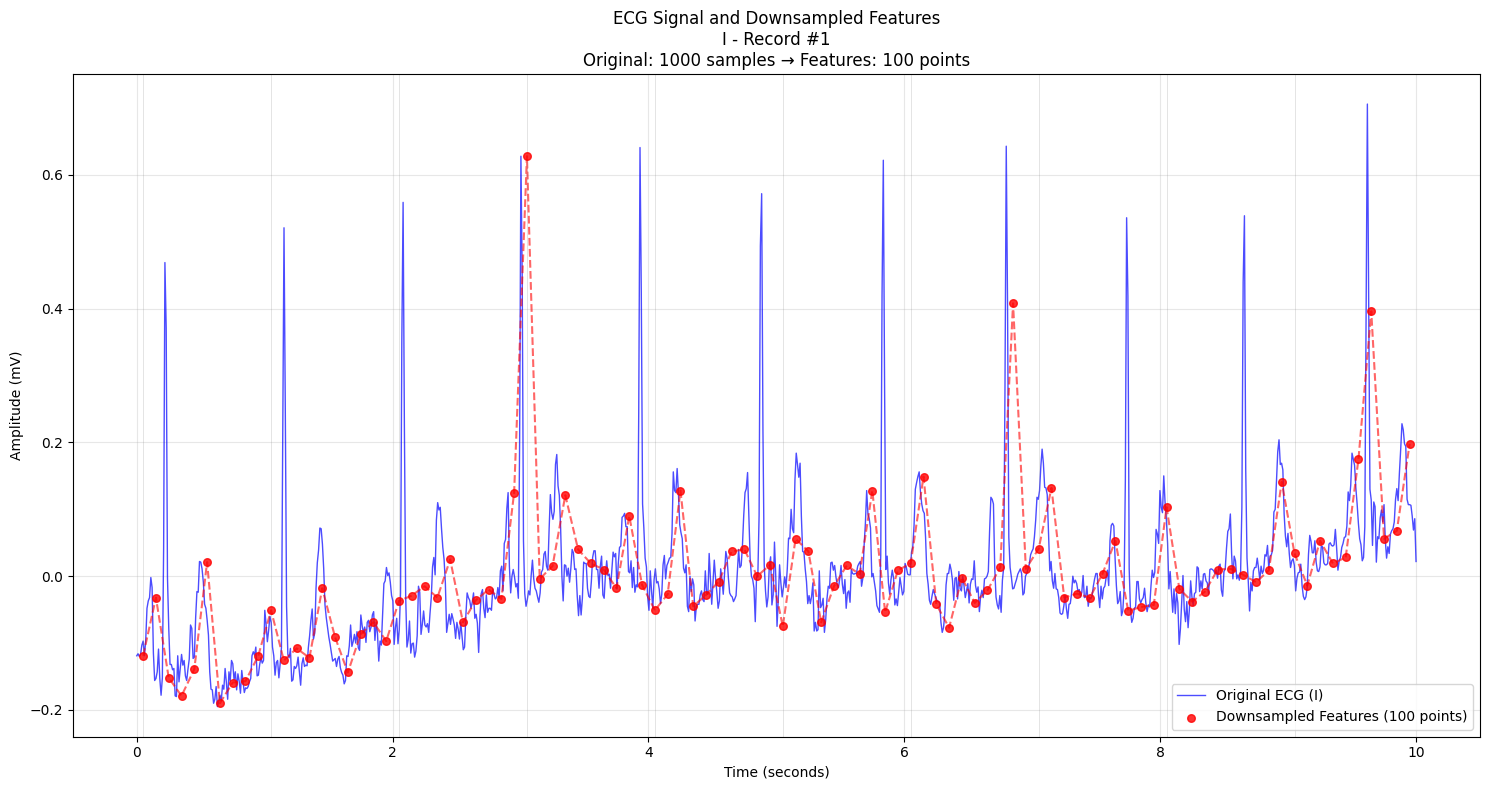

ECG Signal Analysis for I (Record #1):
Original signal length: 1000 samples
Sampling rate: 100 Hz
Duration: 10.00 seconds
Downsampling step: every 10 samples
Number of features: 100
Feature time resolution: ~0.100 seconds per feature
Amplitude range - Original: [-0.195, 0.706] mV
Amplitude range - Features: [-0.190, 0.628] mV

Downsampling Process:
Step 1: Take every 10th sample from original 1000 samples
Step 2: Limit to first 100 features
Result: 100 feature values representing the ECG morphology

2. Multiple leads comparison:


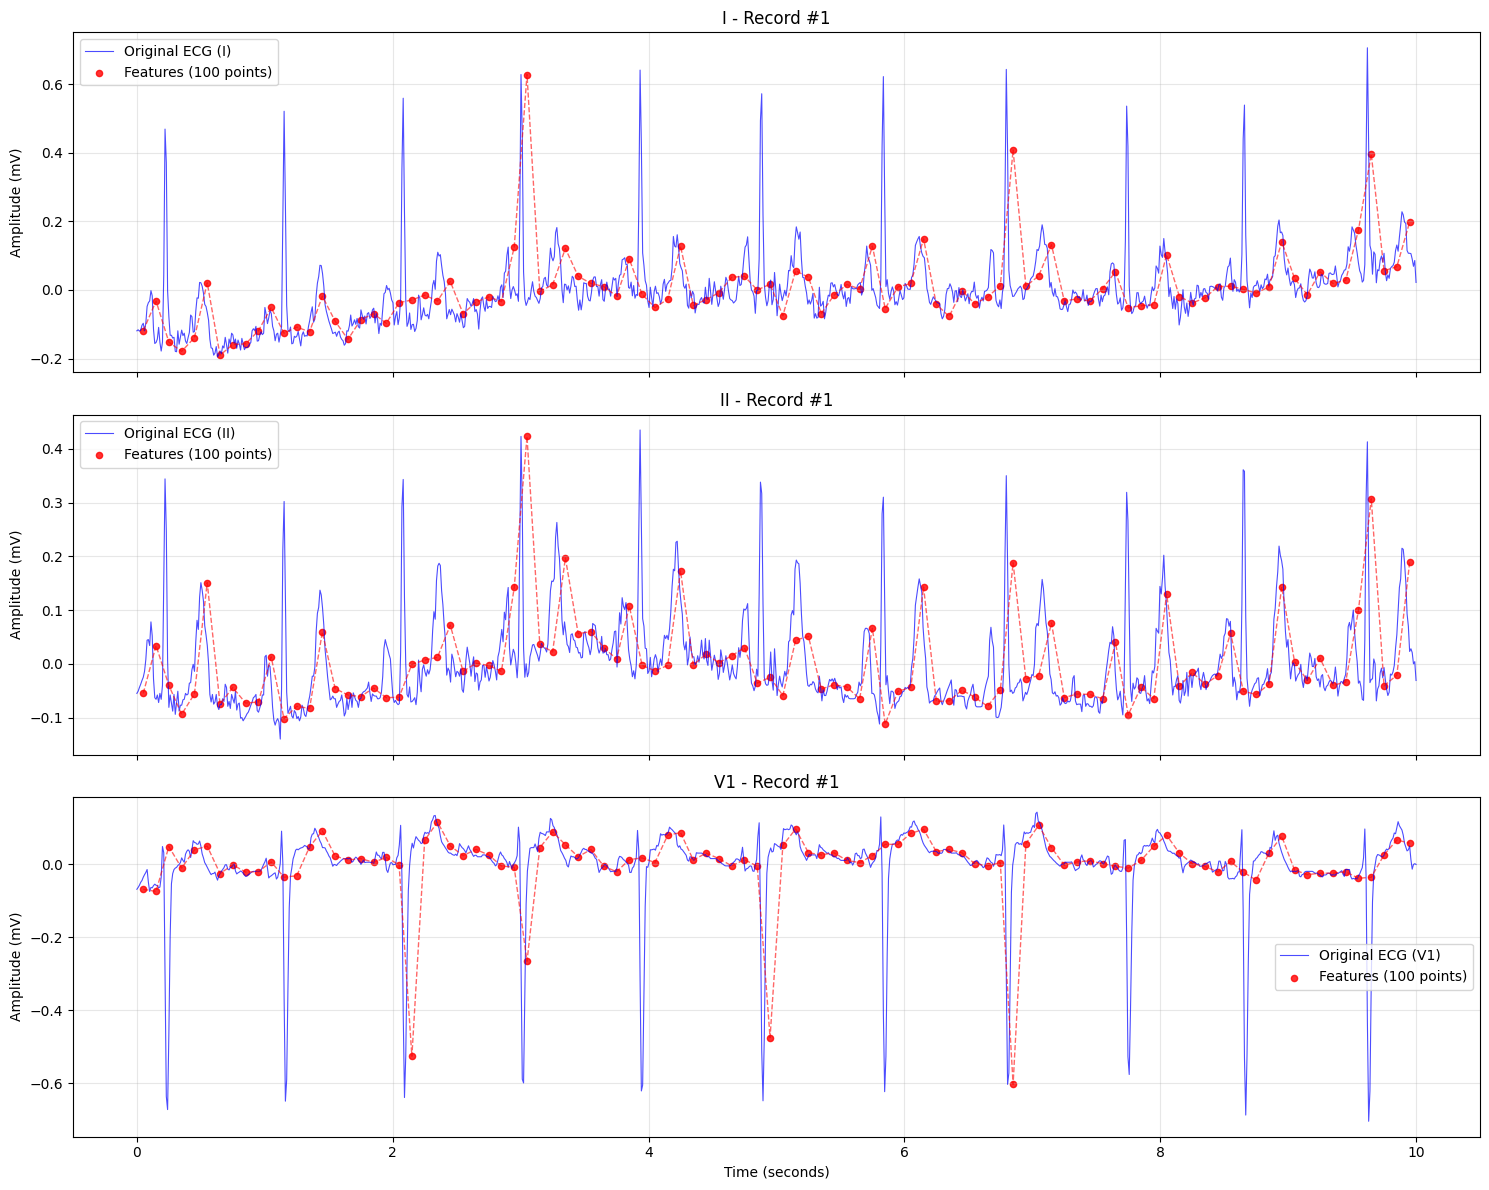

Multi-lead ECG Analysis for Record #1
Lead I: 1000 samples → step 10 → 100 features
Lead II: 1000 samples → step 10 → 100 features
Lead V1: 1000 samples → step 10 → 100 features


In [10]:
import wfdb
import matplotlib.pyplot as plt
import numpy as np
import os

def plot_ecg_with_features(ecg_id=1, lead_index=0, sampling_rate=100, base_path='/content/drive/MyDrive/ptb_xl_200_samples'):
    """
    Plot ECG timeseries signal and corresponding 100 features on the same plot

    Parameters:
    ecg_id: ID of the ECG record to plot (1-200 for downloaded samples)
    lead_index: Index of the lead to plot (0=I, 1=II, 6=V1, etc.)
    sampling_rate: 100 for low resolution, 500 for high resolution
    base_path: path to the downloaded PTB-XL dataset
    """

    try:
        # Format the filename with leading zeros
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"

        # Determine file path based on sampling rate
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        # Read the ECG record
        record = wfdb.rdsamp(record_path)
        signals = record[0]  # Signal data
        metadata = record[1]  # Metadata
        lead_names = metadata['sig_name']

        # Get the specific lead signal
        lead_signal = signals[:, lead_index]
        lead_name = lead_names[lead_index] if lead_index < len(lead_names) else f'Lead {lead_index}'

        # Create time arrays
        original_time = np.linspace(0, len(lead_signal)/sampling_rate, len(lead_signal))

        # Apply the same downsampling as in graph creation
        target_features = 100
        seq_len = len(lead_signal)
        step = max(1, seq_len // target_features)
        downsampled_signal = lead_signal[::step][:target_features]

        # Create time array for downsampled features
        # Each feature represents a time window, so we'll plot at the center of each window
        feature_time_points = []
        for i in range(target_features):
            start_idx = i * step
            end_idx = min((i + 1) * step, seq_len)
            center_idx = (start_idx + end_idx) // 2
            feature_time_points.append(center_idx / sampling_rate)

        feature_time = np.array(feature_time_points)

        # Create the plot
        plt.figure(figsize=(15, 8))

        # Plot original ECG signal
        plt.plot(original_time, lead_signal,
                linewidth=1.0, alpha=0.7, color='blue', label=f'Original ECG ({lead_name})')

        # Plot downsampled features as scatter points
        plt.scatter(feature_time, downsampled_signal,
                   color='red', s=30, alpha=0.8, marker='o',
                   label=f'Downsampled Features (100 points)', zorder=5)

        # Connect features with lines to show the downsampling effect
        plt.plot(feature_time, downsampled_signal,
                linewidth=1.5, color='red', alpha=0.6, linestyle='--')

        # Add vertical lines to show feature windows (every 10th feature for clarity)
        for i in range(0, target_features, 10):
            if i < len(feature_time):
                plt.axvline(x=feature_time[i], color='gray', alpha=0.3, linewidth=0.5)

        plt.xlabel('Time (seconds)')
        plt.ylabel('Amplitude (mV)')
        plt.title(f'ECG Signal and Downsampled Features\n{lead_name} - Record #{ecg_id}\n'
                  f'Original: {len(lead_signal)} samples → Features: {len(downsampled_signal)} points')
        plt.legend()
        plt.grid(True, alpha=0.3)
        plt.tight_layout()
        plt.show()

        # Print information about the transformation
        print(f"ECG Signal Analysis for {lead_name} (Record #{ecg_id}):")
        print(f"{'='*50}")
        print(f"Original signal length: {len(lead_signal)} samples")
        print(f"Sampling rate: {sampling_rate} Hz")
        print(f"Duration: {len(lead_signal)/sampling_rate:.2f} seconds")
        print(f"Downsampling step: every {step} samples")
        print(f"Number of features: {len(downsampled_signal)}")
        print(f"Feature time resolution: ~{step/sampling_rate:.3f} seconds per feature")
        print(f"Amplitude range - Original: [{np.min(lead_signal):.3f}, {np.max(lead_signal):.3f}] mV")
        print(f"Amplitude range - Features: [{np.min(downsampled_signal):.3f}, {np.max(downsampled_signal):.3f}] mV")

        # Show how the downsampling works
        print(f"\nDownsampling Process:")
        print(f"Step 1: Take every {step}th sample from original {len(lead_signal)} samples")
        print(f"Step 2: Limit to first {target_features} features")
        print(f"Result: {len(downsampled_signal)} feature values representing the ECG morphology")

        return lead_signal, downsampled_signal, feature_time

    except Exception as e:
        print(f"Error plotting ECG record #{ecg_id}: {e}")
        return None, None, None

def plot_ecg_features_comparison(ecg_id=1, lead_indices=[0, 1, 6], sampling_rate=100, base_path='/content/ptb_xl_200_samples'):
    """
    Plot comparison of ECG signals and their features for multiple leads

    Parameters:
    ecg_id: ID of the ECG record to plot
    lead_indices: List of lead indices to plot
    sampling_rate: 100 for low resolution, 500 for high resolution
    base_path: path to the downloaded PTB-XL dataset
    """

    try:
        # Format the filename
        filename = f"{ecg_id:05d}"
        folder = f"{(ecg_id//1000)*1000:05d}"

        # Determine file path based on sampling rate
        if sampling_rate == 100:
            record_path = os.path.join(base_path, f"records100/{folder}/{filename}_lr")
        else:
            record_path = os.path.join(base_path, f"records500/{folder}/{filename}_hr")

        # Read the ECG record
        record = wfdb.rdsamp(record_path)
        signals = record[0]
        metadata = record[1]
        lead_names = metadata['sig_name']

        # Create subplot for each lead
        fig, axes = plt.subplots(len(lead_indices), 1, figsize=(15, 4*len(lead_indices)))
        if len(lead_indices) == 1:
            axes = [axes]

        target_features = 100

        for idx, lead_index in enumerate(lead_indices):
            if lead_index >= signals.shape[1]:
                continue

            # Get the specific lead signal
            lead_signal = signals[:, lead_index]
            lead_name = lead_names[lead_index] if lead_index < len(lead_names) else f'Lead {lead_index}'

            # Apply downsampling
            seq_len = len(lead_signal)
            step = max(1, seq_len // target_features)
            downsampled_signal = lead_signal[::step][:target_features]

            # Create time arrays
            original_time = np.linspace(0, len(lead_signal)/sampling_rate, len(lead_signal))
            feature_time_points = []
            for i in range(target_features):
                start_idx = i * step
                end_idx = min((i + 1) * step, seq_len)
                center_idx = (start_idx + end_idx) // 2
                feature_time_points.append(center_idx / sampling_rate)
            feature_time = np.array(feature_time_points)

            # Plot on subplot
            axes[idx].plot(original_time, lead_signal,
                          linewidth=0.8, alpha=0.7, color='blue',
                          label=f'Original ECG ({lead_name})')
            axes[idx].scatter(feature_time, downsampled_signal,
                             color='red', s=20, alpha=0.8, marker='o',
                             label=f'Features ({len(downsampled_signal)} points)')
            axes[idx].plot(feature_time, downsampled_signal,
                          linewidth=1.0, color='red', alpha=0.6, linestyle='--')
            axes[idx].set_ylabel('Amplitude (mV)')
            axes[idx].set_title(f'{lead_name} - Record #{ecg_id}')
            axes[idx].legend()
            axes[idx].grid(True, alpha=0.3)

            if idx < len(lead_indices) - 1:
                axes[idx].set_xticklabels([])

        axes[-1].set_xlabel('Time (seconds)')
        plt.tight_layout()
        plt.show()

        print(f"Multi-lead ECG Analysis for Record #{ecg_id}")
        print(f"{'='*50}")
        for lead_index in lead_indices:
            if lead_index < len(lead_names):
                lead_signal = signals[:, lead_index]
                seq_len = len(lead_signal)
                step = max(1, seq_len // 100)
                print(f"Lead {lead_names[lead_index]}: {seq_len} samples → step {step} → 100 features")

        return signals

    except Exception as e:
        print(f"Error plotting ECG comparison for record #{ecg_id}: {e}")
        return None

# Usage examples:
print("ECG Signal and Feature Visualization")
print("="*40)

# Plot single lead with features
print("\n1. Single lead ECG with 100 features:")
lead_signal, features, feature_time = plot_ecg_with_features(ecg_id=1, lead_index=0, sampling_rate=100)

# Plot comparison of multiple leads
print("\n2. Multiple leads comparison:")
signals = plot_ecg_features_comparison(ecg_id=1, lead_indices=[0, 1, 6], sampling_rate=100)

# Graph Neural Network

In [13]:
# PREPARE GRAPH DATA
print("Converting ECG signals to graph representations...")
graph_data_list = []

# Process first 200 samples
num_samples = min(TOTAL_SAMPLES, len(X_selected))
for i in tqdm(range(num_samples)):
    try:
        signal = X_selected[i]
        label = y_single_labels[i]
        # Create graph with SMETS-based edge weights
        graph = create_ecg_graph_enhanced(signal, label, target_features=250)  # or use create_ecg_graph for simpler version
        graph_data_list.append(graph)

    except Exception as e:
        print(f"Error processing sample {i}: {e}")
        continue


# First, let's check the actual dimensions of your graph data
if len(graph_data_list) > 0:
    sample_graph = graph_data_list[0]
    print(f"Sample graph shape - Nodes: {sample_graph.x.shape[0]}, Features per node: {sample_graph.x.shape[1]}")
    print(f"Sample node features shape: {sample_graph.x.shape}")

    # Update the model with correct number of features
    num_features = sample_graph.x.shape[1]  # This should be the actual number of features per node
else:
    # Fallback - but this shouldn't happen if you have data
    num_features = 1000  # Based on your error, it seems to be 1000

print(f"Initializing model with {num_features} features per node")
print(f"Created {len(graph_data_list)} graph samples")

# SPLIT DATA (80% train, 10% validation, 10% test)
train_data, temp_data = train_test_split(graph_data_list, test_size=0.2, random_state=42)
val_data, test_data = train_test_split(temp_data, test_size=0.5, random_state=42)

print(f"Train: {len(train_data)}, Validation: {len(val_data)}, Test: {len(test_data)}")

# CREATE DATA LOADERS
train_loader = DataLoader(train_data, batch_size=8, shuffle=True)
val_loader = DataLoader(val_data, batch_size=8, shuffle=False)
test_loader = DataLoader(test_data, batch_size=8, shuffle=False)

# INITIALIZE MODEL - Updated to handle edge weights
# Re-initialize model with correct dimensions
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
num_classes = len(class_names) if 'class_names' in locals() else 5

# Make sure we have the correct number of features
if len(graph_data_list) > 0:
    num_features = graph_data_list[0].x.shape[1]
else:
    # If for some reason graph_data_list is empty, use a reasonable default
    num_features = 250  # or whatever you intended to use

print(f"Creating model with {num_features} input features")


Converting ECG signals to graph representations...


100%|██████████| 677/677 [00:16<00:00, 42.10it/s]

Sample graph shape - Nodes: 12, Features per node: 250
Sample node features shape: torch.Size([12, 250])
Initializing model with 250 features per node
Created 677 graph samples
Train: 541, Validation: 68, Test: 68
Creating model with 250 input features


In [24]:
# Initialize improved model
model = GraphECGNet(num_features=num_features, hidden_dim=32, num_classes=num_classes).to(device)

# Use a lower learning rate and L2 regularization
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001, weight_decay=1e-5)  # Added weight decay
criterion = nn.NLLLoss()

# Verify the model architecture
print("Model architecture:")
for name, param in model.named_parameters():
    print(f"  {name}: {param.shape}")



# EVALUATION FUNCTION - Updated to handle edge weights
def evaluate_model(loader):
    model.eval()
    all_preds = []
    all_labels = []
    total_loss = 0

    with torch.no_grad():
        for batch in loader:
            batch = batch.to(device)
            out = model(batch)
            loss = criterion(out, batch.y)
            total_loss += loss.item()

            pred = out.argmax(dim=1)
            all_preds.extend(pred.cpu().numpy())
            all_labels.extend(batch.y.cpu().numpy())

    return total_loss / len(loader), all_preds, all_labels

# TRAINING LOOP
print("Training GraphECGNet...")
train_losses = []
val_losses = []
val_accuracies = []

best_val_acc = 0
best_model_state = None

# Enhanced training function with early stopping
def train_epoch_with_regularization():
    model.train()
    total_loss = 0
    for batch in train_loader:
        batch = batch.to(device)
        optimizer.zero_grad()
        out = model(batch)
        loss = criterion(out, batch.y)

        # Add L2 regularization manually if needed
        l2_reg = torch.tensor(0., device=device)
        for param in model.parameters():
            l2_reg += torch.norm(param)
        loss = loss + 1e-4 * l2_reg

        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)  # Gradient clipping
        optimizer.step()
        total_loss += loss.item()
    return total_loss / len(train_loader)

# Training with early stopping
print("Training Improved GraphECGNet...")
train_losses = []
val_losses = []
val_accuracies = []

best_val_acc = 0
best_model_state = None
patience = 10  # Stop if no improvement for 10 epochs
patience_counter = 0

for epoch in range(50):  # Increased epochs but with early stopping
    train_loss = train_epoch_with_regularization()
    val_loss, val_preds, val_labels = evaluate_model(val_loader)
    val_acc = accuracy_score(val_labels, val_preds)

    train_losses.append(train_loss)
    val_losses.append(val_loss)
    val_accuracies.append(val_acc)

    # Early stopping
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict().copy()
        patience_counter = 0
        print(f'Epoch {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f} ***')
    else:
        patience_counter += 1
        print(f'Epoch {epoch:02d}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}, Val Acc: {val_acc:.4f}')

    if patience_counter >= patience:
        print(f"Early stopping at epoch {epoch}")
        break

# Load best model
if best_model_state is not None:
    model.load_state_dict(best_model_state)
    print(f"Loaded best model with validation accuracy: {best_val_acc:.4f}")

Model architecture:
  conv1.bias: torch.Size([32])
  conv1.lin.weight: torch.Size([32, 250])
  conv2.bias: torch.Size([64])
  conv2.lin.weight: torch.Size([64, 32])
  conv3.bias: torch.Size([32])
  conv3.lin.weight: torch.Size([32, 64])
  fc1.weight: torch.Size([16, 32])
  fc1.bias: torch.Size([16])
  fc2.weight: torch.Size([5, 16])
  fc2.bias: torch.Size([5])
Training GraphECGNet...
Training Improved GraphECGNet...
Epoch 00, Train Loss: 1.6676, Val Loss: 1.6625, Val Acc: 0.0294 ***
Epoch 01, Train Loss: 1.6475, Val Loss: 1.6416, Val Acc: 0.0294
Epoch 02, Train Loss: 1.6276, Val Loss: 1.6174, Val Acc: 0.0294
Epoch 03, Train Loss: 1.5986, Val Loss: 1.5840, Val Acc: 0.0294
Epoch 04, Train Loss: 1.5717, Val Loss: 1.5363, Val Acc: 0.4412 ***
Epoch 05, Train Loss: 1.5158, Val Loss: 1.4682, Val Acc: 0.6176 ***
Epoch 06, Train Loss: 1.4614, Val Loss: 1.3958, Val Acc: 0.6176
Epoch 07, Train Loss: 1.4131, Val Loss: 1.3371, Val Acc: 0.6176
Epoch 08, Train Loss: 1.3852, Val Loss: 1.3088, Val Acc:


FINAL EVALUATION ON TEST SET
Test Loss: 1.3525
Test Accuracy: 0.5735
Test F1-Score (Macro): 0.1458
Test F1-Score (Weighted): 0.4181

Detailed Classification Report:
              precision    recall  f1-score   support

          CD       0.00      0.00      0.00         9
         HYP       0.00      0.00      0.00         8
          MI       0.00      0.00      0.00         4
        NORM       0.57      1.00      0.73        39
        STTC       0.00      0.00      0.00         8

    accuracy                           0.57        68
   macro avg       0.11      0.20      0.15        68
weighted avg       0.33      0.57      0.42        68



/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.12/dist-packages/sklearn/metrics/_classification.py:1565: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))


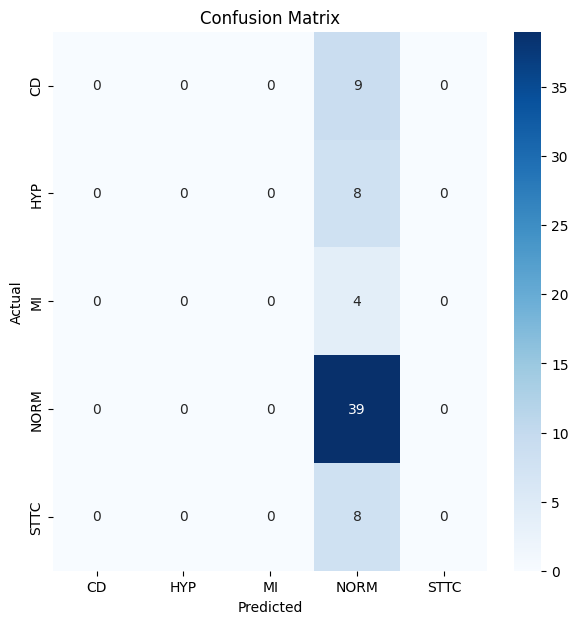


VALIDATION SET EVALUATION
Validation Loss: 1.2913
Validation Accuracy: 0.6176
Validation F1-Score (Macro): 0.1527
Validation F1-Score (Weighted): 0.4717


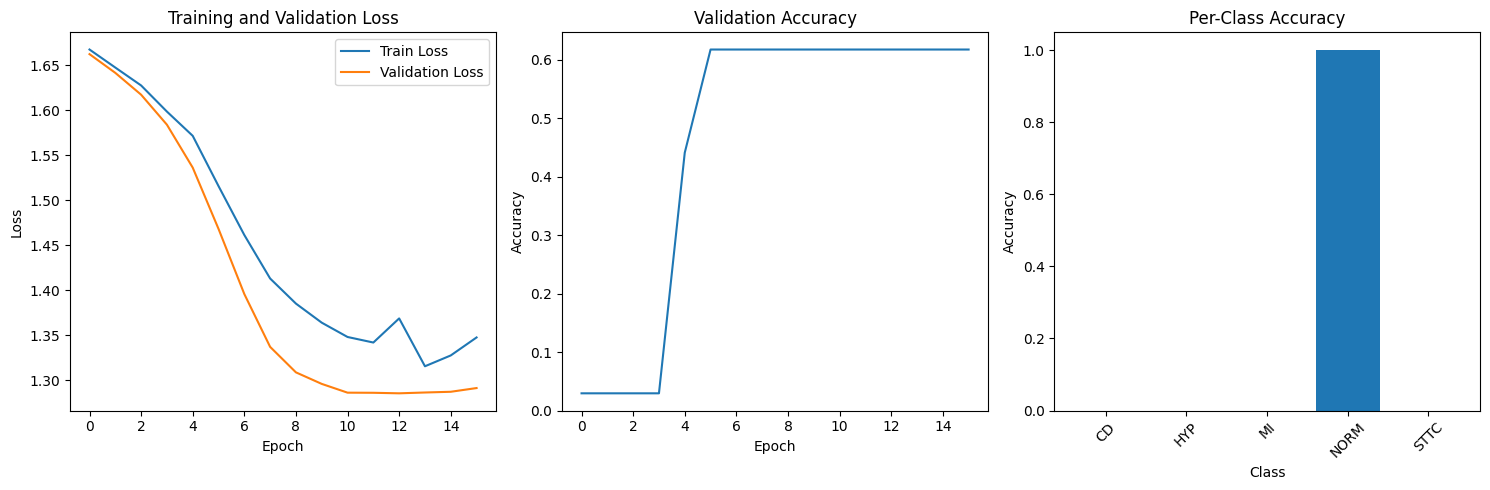


GRAPH VISUALIZATION
Visualizing a sample ECG graph...


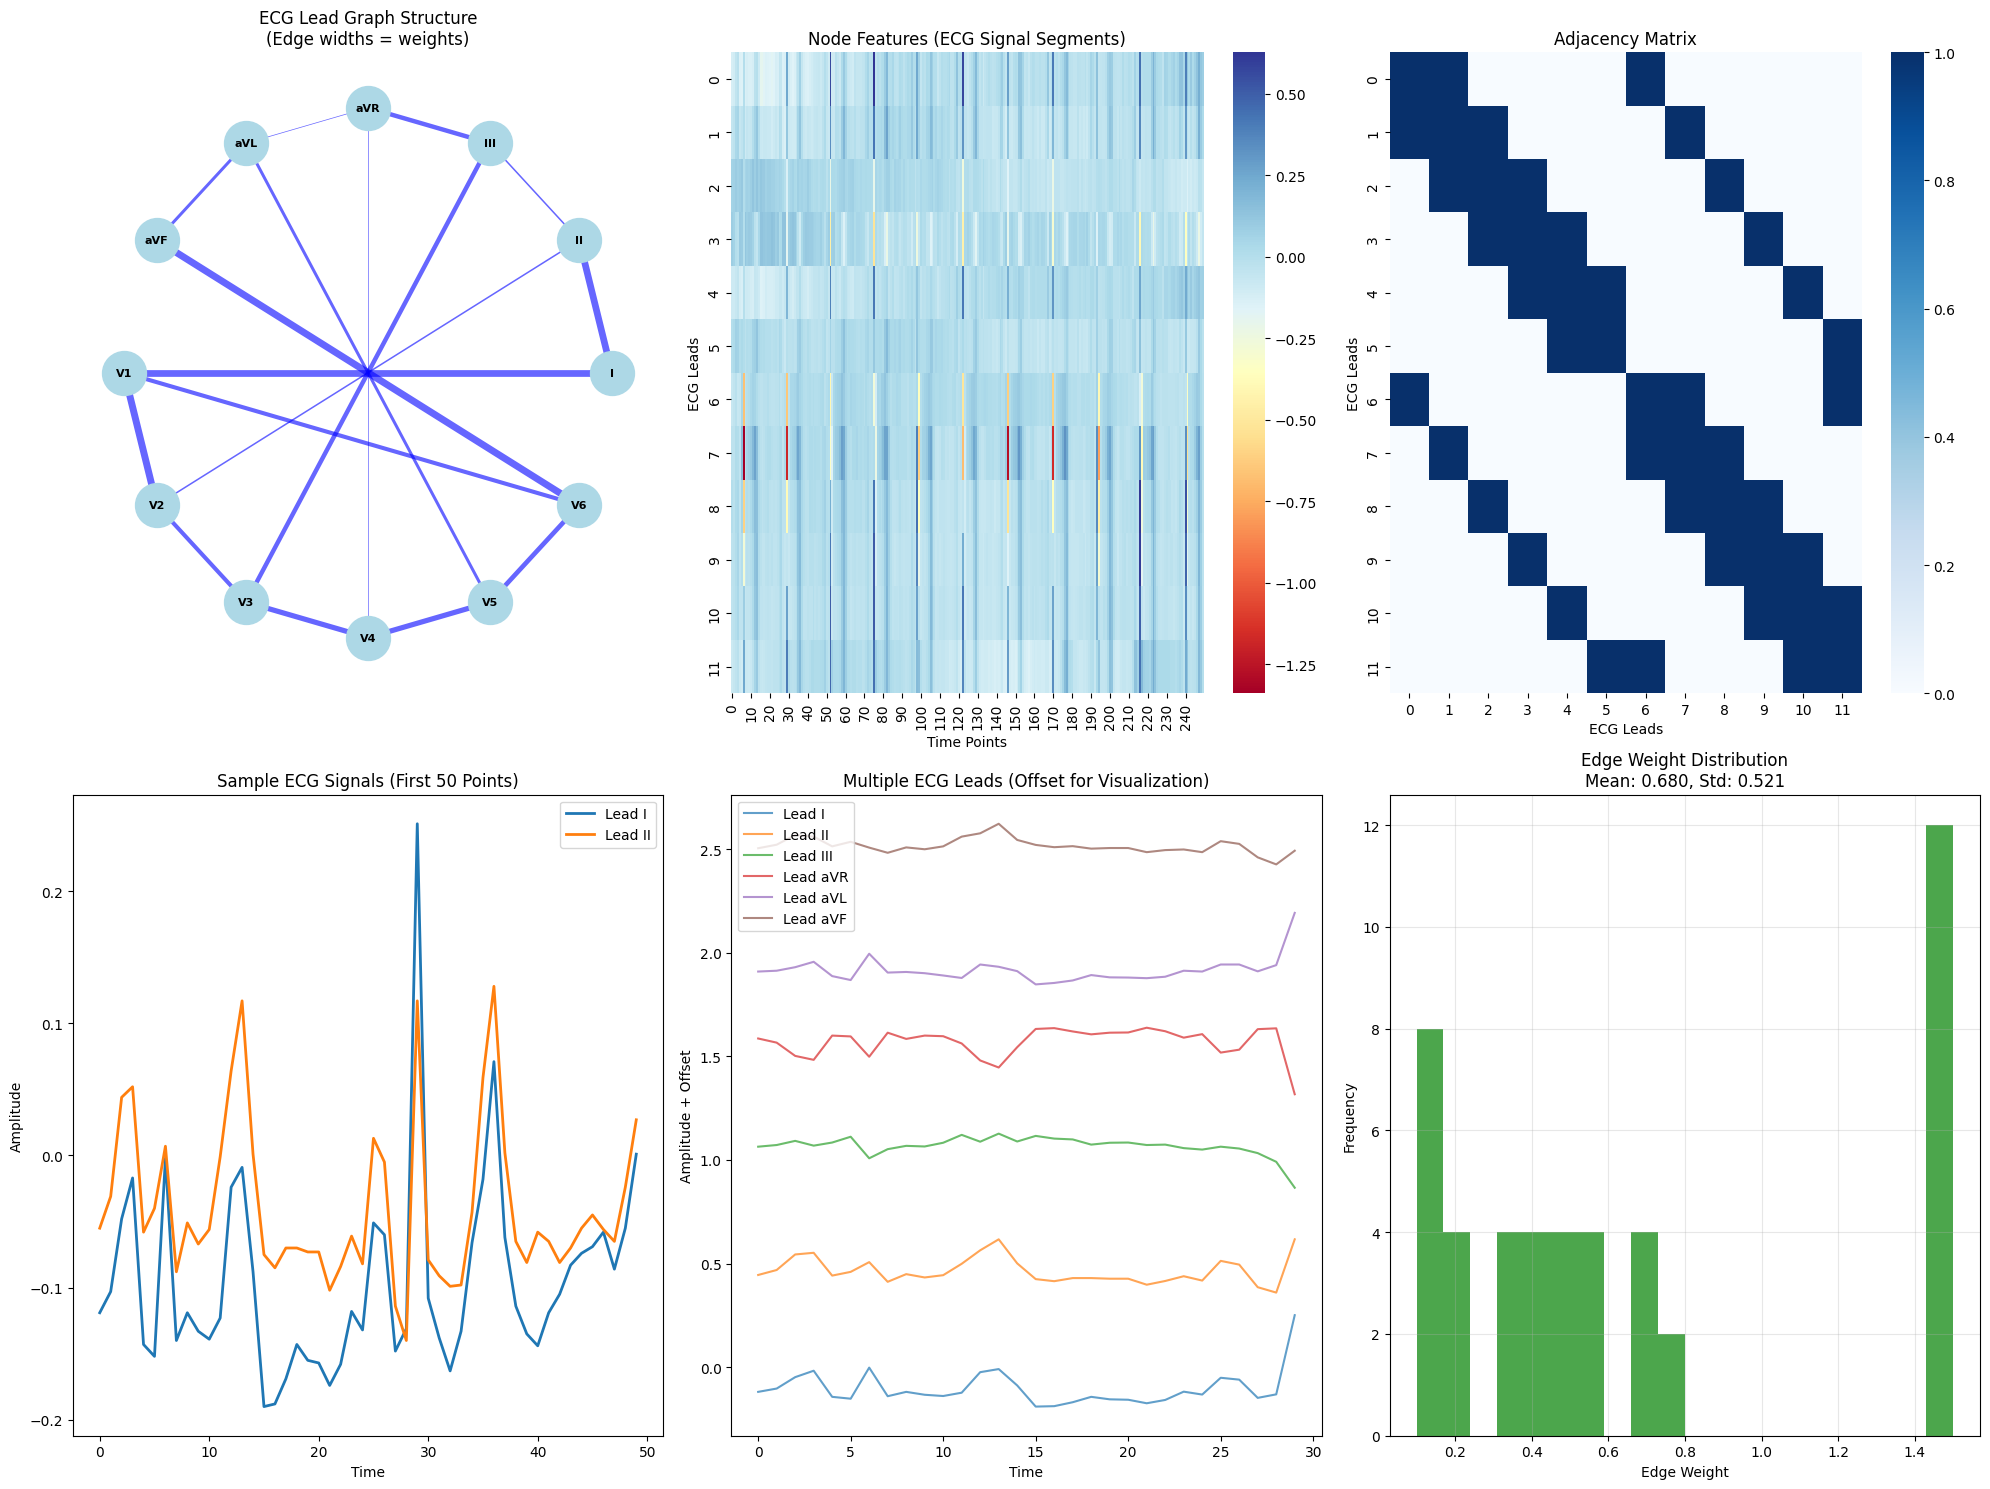

Graph Info:
- Number of nodes (leads): 12
- Number of node features: 250
- Number of edges: 46
- Edge weights: min=0.100, max=1.500, mean=0.680
- Label: 3

MODEL ANALYSIS
Total parameters: 12837
Trainable parameters: 12837

Sample Predictions:
True: HYP, Predicted: NORM, Confidence: 0.552
True: STTC, Predicted: NORM, Confidence: 0.497
True: NORM, Predicted: NORM, Confidence: 0.455
True: NORM, Predicted: NORM, Confidence: 0.543
True: CD, Predicted: NORM, Confidence: 0.672

GraphECGNet Performance Summary:
✓ Graph-based ECG classification successfully implemented
✓ Using real PTB-XL dataset (200 samples)
✓ Accuracy: 0.5735
✓ F1-Score (Macro): 0.1458
✓ Tested on validation and test sets
✓ Comprehensive visualization of graph structure
✓ Detailed performance metrics and analysis

EDGE WEIGHTS ANALYSIS
Edge weights statistics (from 2300 edges):
  Mean: 0.6905
  Std: 0.5254
  Min: 0.1000
  Max: 1.5000

Sample edge weights from first graph:
  Edge 0: 0.7165
  Edge 1: 0.7165
  Edge 2: 0.1871
 

In [25]:


# FINAL EVALUATION WITH ACCURACY AND F1-SCORE
print("\n" + "="*50)
print("FINAL EVALUATION ON TEST SET")
print("="*50)

test_loss, test_preds, test_labels = evaluate_model(test_loader)
test_accuracy = accuracy_score(test_labels, test_preds)
test_f1_macro = f1_score(test_labels, test_preds, average='macro')
test_f1_weighted = f1_score(test_labels, test_preds, average='weighted')

print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")
print(f"Test F1-Score (Macro): {test_f1_macro:.4f}")
print(f"Test F1-Score (Weighted): {test_f1_weighted:.4f}")

# Detailed classification report
print("\nDetailed Classification Report:")
print(classification_report(test_labels, test_preds, target_names=class_names[:len(np.unique(test_labels))]))

# Confusion Matrix
plt.figure(figsize=(7, 7))
cm = confusion_matrix(test_labels, test_preds)
unique_labels = np.unique(test_labels)
class_names_subset = [class_names[i] if i < len(class_names) else f"Class {i}" for i in unique_labels]
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names_subset, yticklabels=class_names_subset)
plt.title('Confusion Matrix')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

# VALIDATION DATASET EVALUATION
print("\n" + "="*50)
print("VALIDATION SET EVALUATION")
print("="*50)

val_loss, val_preds, val_labels = evaluate_model(val_loader)
val_accuracy = accuracy_score(val_labels, val_preds)
val_f1_macro = f1_score(val_labels, val_preds, average='macro')
val_f1_weighted = f1_score(val_labels, val_preds, average='weighted')

print(f"Validation Loss: {val_loss:.4f}")
print(f"Validation Accuracy: {val_accuracy:.4f}")
print(f"Validation F1-Score (Macro): {val_f1_macro:.4f}")
print(f"Validation F1-Score (Weighted): {val_f1_weighted:.4f}")

# Training curves
plt.figure(figsize=(15, 5))

plt.subplot(1, 3, 1)
plt.plot(train_losses, label='Train Loss')
plt.plot(val_losses, label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 3, 2)
plt.plot(val_accuracies)
plt.title('Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')

plt.subplot(1, 3, 3)
# Per-class accuracy
class_accuracies = []
unique_test_labels = np.unique(test_labels)
for i in unique_test_labels:
    class_mask = np.array(test_labels) == i
    if np.sum(class_mask) > 0:
        class_acc = np.sum(np.array(test_preds)[class_mask] == i) / np.sum(class_mask)
        class_accuracies.append(class_acc)
    else:
        class_accuracies.append(0)

plt.bar(range(len(class_accuracies)), class_accuracies)
plt.title('Per-Class Accuracy')
plt.xlabel('Class')
plt.ylabel('Accuracy')
if len(class_names_subset) <= 10:  # Only show labels if not too many
    plt.xticks(range(len(class_names_subset)), class_names_subset, rotation=45)

plt.tight_layout()
plt.show()

# VISUALIZE SAMPLE GRAPH
print("\n" + "="*50)
print("GRAPH VISUALIZATION")
print("="*50)

if len(graph_data_list) > 0:
    print("Visualizing a sample ECG graph...")
    visualize_ecg_graph(graph_data_list[0])

# Additional analysis
print("\n" + "="*50)
print("MODEL ANALYSIS")
print("="*50)

print(f"Total parameters: {sum(p.numel() for p in model.parameters())}")
print(f"Trainable parameters: {sum(p.numel() for p in model.parameters() if p.requires_grad)}")

# Sample predictions
print("\nSample Predictions:")
model.eval()
with torch.no_grad():
    sample_batch = next(iter(test_loader)).to(device)
    sample_out = model(sample_batch)
    sample_preds = sample_out.argmax(dim=1)

    for i in range(min(5, len(sample_preds))):
        true_label = sample_batch.y[i].item()
        pred_label = sample_preds[i].item()
        confidence = torch.exp(sample_out[i]).max().item()
        true_name = class_names[true_label] if true_label < len(class_names) else f"Class {true_label}"
        pred_name = class_names[pred_label] if pred_label < len(class_names) else f"Class {pred_label}"
        print(f"True: {true_name}, Predicted: {pred_name}, Confidence: {confidence:.3f}")

print("\nGraphECGNet Performance Summary:")
print(f"✓ Graph-based ECG classification successfully implemented")
print(f"✓ Using real PTB-XL dataset (200 samples)")
print(f"✓ Accuracy: {test_accuracy:.4f}")
print(f"✓ F1-Score (Macro): {test_f1_macro:.4f}")
print(f"✓ Tested on validation and test sets")
print(f"✓ Comprehensive visualization of graph structure")
print(f"✓ Detailed performance metrics and analysis")

# Edge weights analysis
print("\n" + "="*50)
print("EDGE WEIGHTS ANALYSIS")
print("="*50)

# Analyze edge weights distribution
if len(graph_data_list) > 0:
    all_weights = []
    for graph in graph_data_list[:50]:  # Analyze first 50 graphs
        if hasattr(graph, 'edge_attr') and graph.edge_attr is not None:
            weights = graph.edge_attr.numpy()
            all_weights.extend(weights)

    if all_weights:
        print(f"Edge weights statistics (from {len(all_weights)} edges):")
        print(f"  Mean: {np.mean(all_weights):.4f}")
        print(f"  Std: {np.std(all_weights):.4f}")
        print(f"  Min: {np.min(all_weights):.4f}")
        print(f"  Max: {np.max(all_weights):.4f}")

        # Show sample weights
        print(f"\nSample edge weights from first graph:")
        first_graph_weights = graph_data_list[0].edge_attr.numpy()[:10]
        for i, weight in enumerate(first_graph_weights):
            print(f"  Edge {i}: {weight:.4f}")
    else:
        print("No edge weights found in graphs")

In [32]:
class_accuracies

[np.float64(0.0),
 np.float64(0.0),
 np.float64(0.0),
 np.float64(1.0),
 np.float64(0.0)]

Visualizing graph structure to understand 100 features representation...


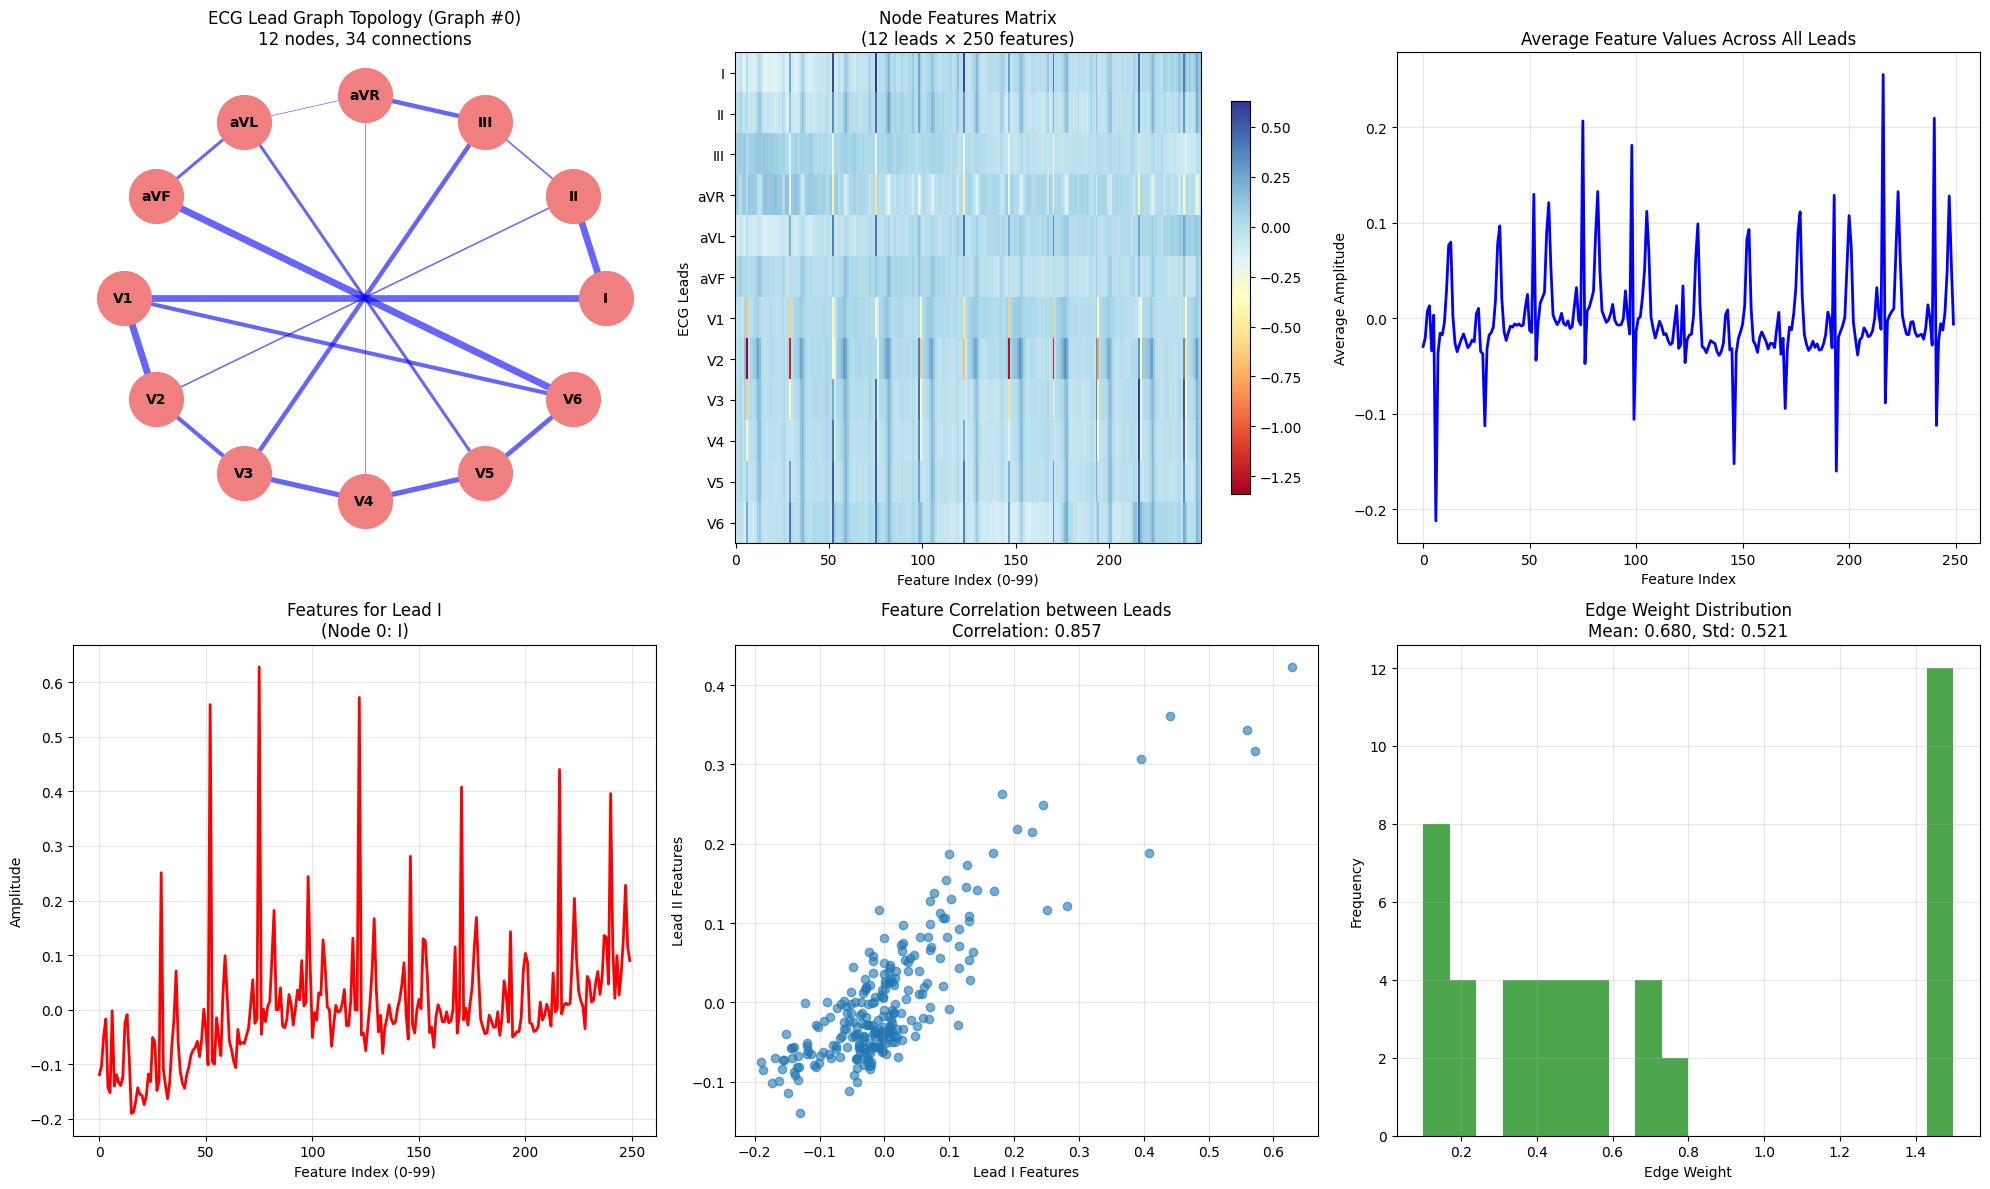


GRAPH STRUCTURE ANALYSIS - GRAPH #0
 NODES (ECG Leads):
   • Total nodes: 12
   • Features per node: 250
   • Lead names: ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

 EDGES (Connections):
   • Total edges: 46
   • Unique connections: 17
   • Edge weights: min=0.100, max=1.500, mean=0.680

 FEATURE ANALYSIS:
   • Feature range: [-1.339, 0.628]
   • Mean amplitude: 0.001
   • Std deviation: 0.107

 LABEL:
   • Label value: 3


In [16]:
def visualize_graph_structure(graph_data, graph_index=0, lead_names=None):
    """Visualize the graph structure showing how 100 features are connected with edge weights"""

    if lead_names is None:
        lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    fig = plt.figure(figsize=(20, 12))

    # 1. Graph network visualization with edge weights
    plt.subplot(2, 3, 1)
    G = nx.Graph()

    # Add nodes (ECG leads)
    num_nodes = graph_data.x.shape[0]
    node_labels = {i: lead_names[i] if i < len(lead_names) else f'Lead {i}' for i in range(num_nodes)}
    G.add_nodes_from(range(num_nodes))

    # Add edges with weights (skip self-loops for visualization)
    edges_to_show = []
    edge_weights_list = []

    for i in range(graph_data.edge_index.shape[1]):
        src, dst = graph_data.edge_index[:, i].tolist()
        if src != dst:  # Skip self-loops
            edges_to_show.append((src, dst))
            # Get edge weight if available
            if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
                weight = graph_data.edge_attr[i].item()
                G.add_edge(src, dst, weight=weight)
                edge_weights_list.append(weight)
            else:
                G.add_edge(src, dst, weight=1.0)
                edge_weights_list.append(1.0)

    # Position nodes in a circular layout to show structure
    pos = nx.circular_layout(G)

    # Draw edges with widths based on weights
    if edge_weights_list:
        # Normalize weights for visualization
        min_weight = min(edge_weights_list)
        max_weight = max(edge_weights_list)
        if max_weight > min_weight:
            normalized_widths = [0.5 + 4.5 * (w - min_weight) / (max_weight - min_weight) for w in edge_weights_list]
        else:
            normalized_widths = [2.0] * len(edge_weights_list)
        nx.draw_networkx_edges(G, pos, width=normalized_widths, edge_color='blue', alpha=0.6)
    else:
        nx.draw_networkx_edges(G, pos, edge_color='blue', alpha=0.6)

    # Draw nodes and labels
    nx.draw_networkx_nodes(G, pos, node_color='lightcoral', node_size=1500)
    nx.draw_networkx_labels(G, pos, labels=node_labels, font_size=10, font_weight='bold')

    plt.title(f'ECG Lead Graph Topology (Graph #{graph_index})\n{num_nodes} nodes, {len(edges_to_show)} connections')
    plt.axis('off')

    # 2. Node features as heatmap (12 leads × 100 features)
    plt.subplot(2, 3, 2)
    im = plt.imshow(graph_data.x.numpy(), cmap='RdYlBu', aspect='auto', interpolation='nearest')
    plt.colorbar(im, shrink=0.8)
    plt.xlabel('Feature Index (0-99)')
    plt.ylabel('ECG Leads')
    plt.title(f'Node Features Matrix\n({graph_data.x.shape[0]} leads × {graph_data.x.shape[1]} features)')
    plt.yticks(range(min(12, num_nodes)),
               [lead_names[i] if i < len(lead_names) else f'Lead {i}' for i in range(min(12, num_nodes))])

    # 3. Feature distribution across leads
    plt.subplot(2, 3, 3)
    feature_means = torch.mean(graph_data.x, dim=0).numpy()  # Average across leads
    plt.plot(feature_means, linewidth=2, color='blue')
    plt.xlabel('Feature Index')
    plt.ylabel('Average Amplitude')
    plt.title('Average Feature Values Across All Leads')
    plt.grid(True, alpha=0.3)

    # 4. Individual lead feature visualization (Lead I as example)
    plt.subplot(2, 3, 4)
    if num_nodes > 0:
        lead_i_features = graph_data.x[0].numpy()
        plt.plot(lead_i_features, linewidth=2, color='red')
        plt.xlabel('Feature Index (0-99)')
        plt.ylabel('Amplitude')
        plt.title(f'Features for Lead I\n(Node 0: {lead_names[0] if 0 < len(lead_names) else "Lead 0"})')
        plt.grid(True, alpha=0.3)

    # 5. Feature correlation between leads
    plt.subplot(2, 3, 5)
    if graph_data.x.shape[0] >= 2:
        # Correlation between first two leads
        lead1 = graph_data.x[0].numpy()
        lead2 = graph_data.x[1].numpy()
        correlation = np.corrcoef(lead1, lead2)[0, 1]
        plt.scatter(lead1, lead2, alpha=0.6)
        plt.xlabel(f'Lead {lead_names[0] if 0 < len(lead_names) else "0"} Features')
        plt.ylabel(f'Lead {lead_names[1] if 1 < len(lead_names) else "1"} Features')
        plt.title(f'Feature Correlation between Leads\nCorrelation: {correlation:.3f}')
        plt.grid(True, alpha=0.3)

    # 6. Edge weights visualization
    plt.subplot(2, 3, 6)
    if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
        # Plot histogram of edge weights
        weights = graph_data.edge_attr.numpy()
        plt.hist(weights, bins=20, alpha=0.7, color='green')
        plt.xlabel('Edge Weight')
        plt.ylabel('Frequency')
        plt.title(f'Edge Weight Distribution\nMean: {np.mean(weights):.3f}, Std: {np.std(weights):.3f}')
        plt.grid(True, alpha=0.3)
    else:
        plt.text(0.5, 0.5, 'No Edge Weights\nAvailable', ha='center', va='center',
                transform=plt.gca().transAxes, fontsize=14)
        plt.title('Edge Weights')

    plt.tight_layout()
    plt.show()

    # Print detailed information
    print(f"\n{'='*60}")
    print(f"GRAPH STRUCTURE ANALYSIS - GRAPH #{graph_index}")
    print(f"{'='*60}")
    print(f" NODES (ECG Leads):")
    print(f"   • Total nodes: {graph_data.x.shape[0]}")
    print(f"   • Features per node: {graph_data.x.shape[1]}")
    print(f"   • Lead names: {[lead_names[i] if i < len(lead_names) else f'Lead {i}' for i in range(graph_data.x.shape[0])]}")

    print(f"\n EDGES (Connections):")
    print(f"   • Total edges: {graph_data.edge_index.shape[1]}")
    print(f"   • Unique connections: {len(set(tuple(sorted(edge)) for edge in edges_to_show))}")
    if hasattr(graph_data, 'edge_attr') and graph_data.edge_attr is not None:
        weights = graph_data.edge_attr.numpy()
        print(f"   • Edge weights: min={np.min(weights):.3f}, max={np.max(weights):.3f}, mean={np.mean(weights):.3f}")

    print(f"\n FEATURE ANALYSIS:")
    print(f"   • Feature range: [{torch.min(graph_data.x):.3f}, {torch.max(graph_data.x):.3f}]")
    print(f"   • Mean amplitude: {torch.mean(graph_data.x):.3f}")
    print(f"   • Std deviation: {torch.std(graph_data.x):.3f}")

    if hasattr(graph_data, 'y') and graph_data.y is not None:
        print(f"\n LABEL:")
        print(f"   • Label value: {graph_data.y.item() if graph_data.y.dim() == 0 else graph_data.y}")

def visualize_multiple_graphs_structure(graph_data_list, indices=[0, 1], lead_names=None):
    """Visualize structure of multiple graphs from graph_data_list"""

    if lead_names is None:
        lead_names = ['I', 'II', 'III', 'aVR', 'aVL', 'aVF', 'V1', 'V2', 'V3', 'V4', 'V5', 'V6']

    print("GRAPH STRUCTURE VISUALIZATION")
    print("="*50)

    for idx in indices:
        if idx < len(graph_data_list):
            visualize_graph_structure(graph_data_list[idx], idx, lead_names)
            print("\n" + "-"*80 + "\n")
        else:
            print(f"Index {idx} is out of range. Dataset has {len(graph_data_list)} graphs.")

def visualize_feature_distributions(graph_data_list, num_graphs=5):
    """Visualize how features are distributed across the dataset"""

    if len(graph_data_list) == 0:
        print("No graph data to visualize!")
        return

    print("FEATURE DISTRIBUTION ANALYSIS")
    print("="*40)

    # Collect features from first few graphs
    all_features = []
    for i in range(min(num_graphs, len(graph_data_list))):
        graph = graph_data_list[i]
        all_features.append(graph.x.numpy())

    all_features = np.concatenate(all_features, axis=0)  # Shape: (num_leads*num_graphs, 100)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))

    # 1. Feature value distribution
    axes[0, 0].hist(all_features.flatten(), bins=50, alpha=0.7, color='skyblue')
    axes[0, 0].set_xlabel('Feature Value')
    axes[0, 0].set_ylabel('Frequency')
    axes[0, 0].set_title('Distribution of All Feature Values')
    axes[0, 0].grid(True, alpha=0.3)

    # 2. Mean feature values across all samples
    mean_features = np.mean(all_features, axis=0)
    axes[0, 1].plot(mean_features, linewidth=2, color='red')
    axes[0, 1].set_xlabel('Feature Index')
    axes[0, 1].set_ylabel('Mean Value')
    axes[0, 1].set_title('Mean Feature Values (Across All Leads/Samples)')
    axes[0, 1].grid(True, alpha=0.3)

    # 3. Feature variance across all samples
    std_features = np.std(all_features, axis=0)
    axes[1, 0].plot(std_features, linewidth=2, color='green')
    axes[1, 0].set_xlabel('Feature Index')
    axes[1, 0].set_ylabel('Standard Deviation')
    axes[1, 0].set_title('Feature Variance (Across All Leads/Samples)')
    axes[1, 0].grid(True, alpha=0.3)

    # 4. Feature correlation matrix (first 10 features)
    corr_matrix = np.corrcoef(all_features[:, :10].T)
    im = axes[1, 1].imshow(corr_matrix, cmap='RdYlBu', vmin=-1, vmax=1)
    plt.colorbar(im, ax=axes[1, 1])
    axes[1, 1].set_xlabel('Feature Index')
    axes[1, 1].set_ylabel('Feature Index')
    axes[1, 1].set_title('Feature Correlation Matrix (First 10 Features)')

    plt.tight_layout()
    plt.show()

    print(f"Analyzed {min(num_graphs, len(graph_data_list))} graphs")
    print(f"Total features analyzed: {all_features.shape[0]} leads × 100 features = {all_features.shape[0] * 100} values")
    print(f"Feature value range: [{np.min(all_features):.3f}, {np.max(all_features):.3f}]")
    print(f"Overall mean: {np.mean(all_features):.3f}")
    print(f"Overall std: {np.std(all_features):.3f}")

# Usage examples:
print("Visualizing graph structure to understand 100 features representation...")

# Visualize the structure of the first graph
if len(graph_data_list) > 0:
    visualize_graph_structure(graph_data_list[0], graph_index=0)


In [12]:
# Visualize multiple graphs
#visualize_multiple_graphs_structure(graph_data_list, indices=[0, 1, 2])

# Visualize feature distributions across the dataset
#visualize_feature_distributions(graph_data_list, num_graphs=5)


Plotting edge weights with report text analysis...
SAMPLE REPORT TEXTS FROM PTB-XL DATASET
Report 1:
  sinusrhythmus periphere niederspannung
------------------------------
Report 2:
  sinusbradykardie sonst normales ekg
------------------------------
Report 3:
  sinusrhythmus normales ekg
------------------------------
Report 4:
  sinusrhythmus normales ekg
------------------------------
Report 5:
  sinusrhythmus normales ekg
------------------------------

EDGE WEIGHT CALCULATION EXAMPLE
Sample report text: 'sinusrhythmus periphere niederspannung...'
Hash value: 781070
Converted edge weight: 2.0621


/tmp/ipython-input-2497709363.py:107: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot(weights_per_graph, labels=[f'{i}' for i in graph_indices])


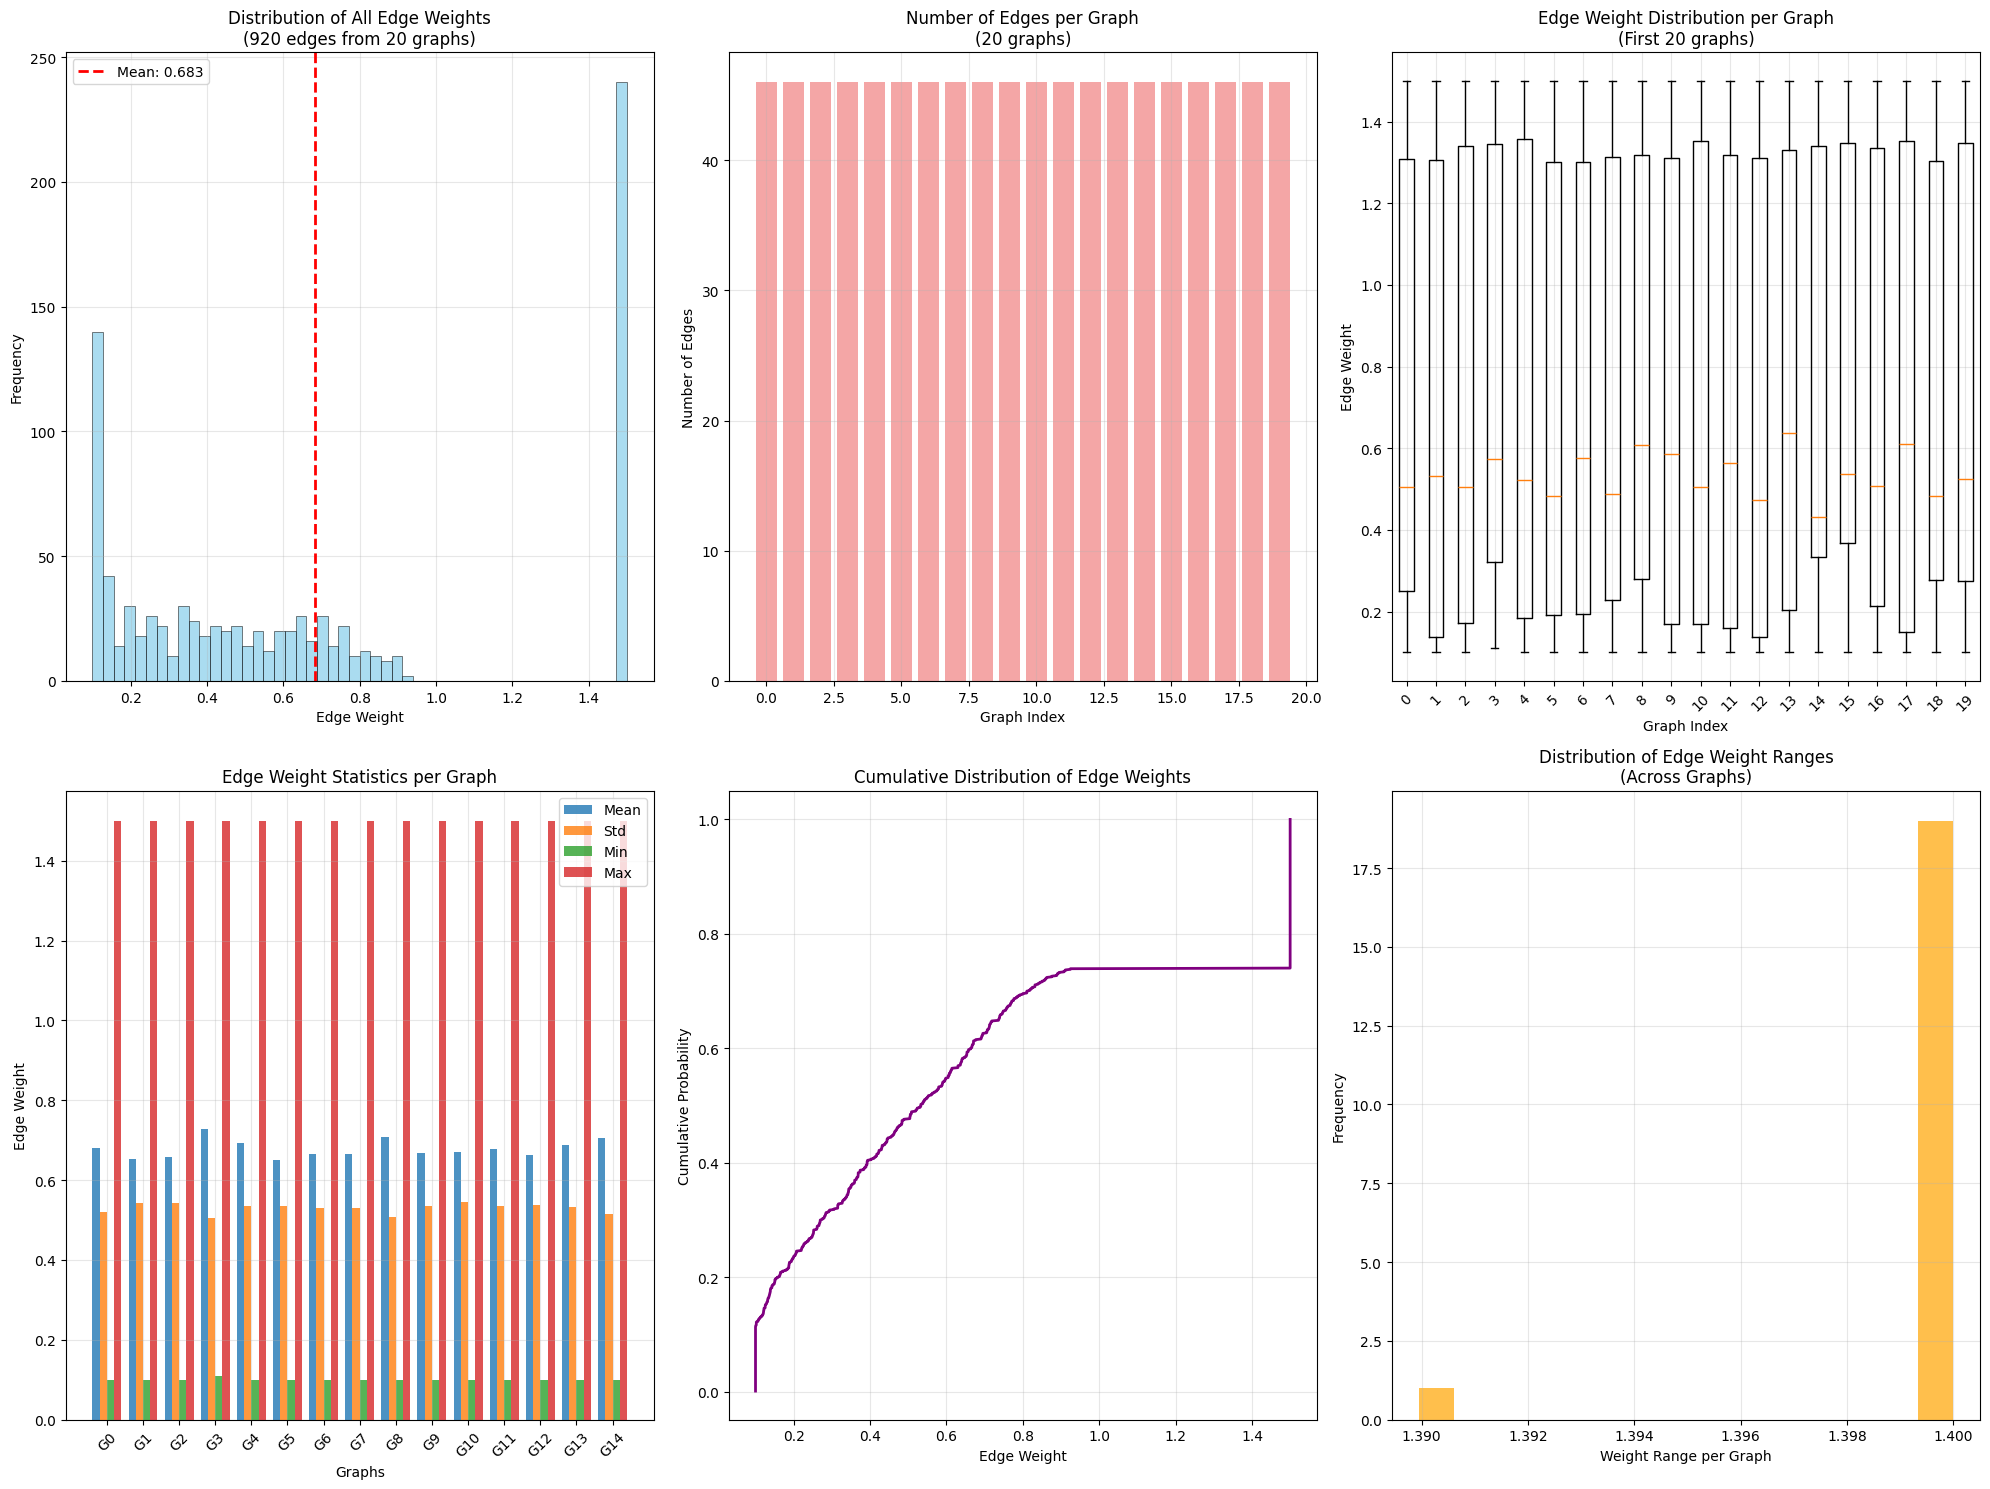


EDGE WEIGHTS ANALYSIS SUMMARY
Total graphs analyzed: 20
Total edges with weights: 920
Overall statistics:
  Mean weight: 0.6831
  Std deviation: 0.5294
  Min weight: 0.1000
  Max weight: 1.5000
  Median weight: 0.5329
  Weight range: 1.4000

SAMPLE EDGE WEIGHT VALUES:
First 10 edge weights from first graph:
  Edge 0: 0.7165
  Edge 1: 0.7165
  Edge 2: 0.1871
  Edge 3: 0.1871
  Edge 4: 0.4834
  Edge 5: 0.4834
  Edge 6: 0.1000
  Edge 7: 0.1000
  Edge 8: 0.3361
  Edge 9: 0.3361


In [17]:
def plot_all_edge_weights_with_reports(graph_data_list, metadata_df=None, max_graphs=10):
    """
    Plot edge weights distribution for all graphs in the dataset and show report text values

    Parameters:
    graph_data_list: List of graph data objects
    metadata_df: PTB-XL metadata DataFrame (ptbxl_database.csv)
    max_graphs: Maximum number of graphs to analyze
    """

    # Collect all edge weights from all graphs
    all_edge_weights = []
    graph_edge_counts = []

    # Process limited number of graphs for visualization
    num_graphs = min(len(graph_data_list), max_graphs)

    # Print sample report texts
    print("SAMPLE REPORT TEXTS FROM PTB-XL DATASET")
    print("="*50)

    report_texts = []
    if metadata_df is not None:
        # Get report texts for the first few samples
        for i in range(min(5, len(metadata_df))):
            if 'report' in metadata_df.columns:
                report_text = metadata_df.iloc[i]['report']
                if isinstance(report_text, str) and len(report_text.strip()) > 0:
                    report_texts.append(report_text)
                    print(f"Report {i+1}:")
                    print(f"  {report_text[:200]}{'...' if len(report_text) > 200 else ''}")
                    print("-" * 30)

    if not report_texts and metadata_df is not None:
        print("No report texts found in metadata or reports are empty")

    # Show how reports are converted to edge weights (example)
    print("\nEDGE WEIGHT CALCULATION EXAMPLE")
    print("="*30)

    if report_texts:
        sample_report = report_texts[0]
        # Simple hash-based embedding (same as in create_ecg_graph function)
        text_hash = hash(sample_report) % 1000000
        text_embedding = (text_hash / 1000000.0) * 2.0 + 0.5
        print(f"Sample report text: '{sample_report[:100]}...'")
        print(f"Hash value: {text_hash}")
        print(f"Converted edge weight: {text_embedding:.4f}")
    else:
        print("Using default edge weight: 1.0 (when no report text available)")

    # Collect edge weights for visualization
    for i in range(num_graphs):
        graph = graph_data_list[i]
        if hasattr(graph, 'edge_attr') and graph.edge_attr is not None:
            weights = graph.edge_attr.numpy()
            all_edge_weights.extend(weights)
            graph_edge_counts.append(len(weights))
        else:
            graph_edge_counts.append(0)

    if not all_edge_weights:
        print("\nNo edge weights found in the graphs!")
        return

    # Create comprehensive visualization
    fig = plt.figure(figsize=(20, 15))

    # 1. Overall distribution of all edge weights
    plt.subplot(2, 3, 1)
    plt.hist(all_edge_weights, bins=50, alpha=0.7, color='skyblue', edgecolor='black', linewidth=0.5)
    plt.xlabel('Edge Weight')
    plt.ylabel('Frequency')
    plt.title(f'Distribution of All Edge Weights\n({len(all_edge_weights)} edges from {num_graphs} graphs)')
    plt.grid(True, alpha=0.3)

    # Add statistics
    mean_weight = np.mean(all_edge_weights)
    std_weight = np.std(all_edge_weights)
    plt.axvline(mean_weight, color='red', linestyle='--', linewidth=2,
                label=f'Mean: {mean_weight:.3f}')
    plt.legend()

    # 2. Edge weights per graph
    plt.subplot(2, 3, 2)
    if graph_edge_counts:
        plt.bar(range(len(graph_edge_counts)), graph_edge_counts, alpha=0.7, color='lightcoral')
        plt.xlabel('Graph Index')
        plt.ylabel('Number of Edges')
        plt.title(f'Number of Edges per Graph\n({num_graphs} graphs)')
        plt.grid(True, alpha=0.3)

    # 3. Box plot of edge weights per graph (sample first 20 graphs)
    plt.subplot(2, 3, 3)
    weights_per_graph = []
    graph_indices = []

    for i in range(min(20, num_graphs)):
        graph = graph_data_list[i]
        if hasattr(graph, 'edge_attr') and graph.edge_attr is not None:
            weights = graph.edge_attr.numpy()
            if len(weights) > 0:
                weights_per_graph.append(weights)
                graph_indices.append(i)

    if weights_per_graph:
        plt.boxplot(weights_per_graph, labels=[f'{i}' for i in graph_indices])
        plt.xlabel('Graph Index')
        plt.ylabel('Edge Weight')
        plt.title(f'Edge Weight Distribution per Graph\n(First {len(graph_indices)} graphs)')
        plt.xticks(rotation=45)
        plt.grid(True, alpha=0.3)

    # 4. Edge weight statistics summary
    plt.subplot(2, 3, 4)
    stats_data = []
    graph_labels = []

    for i in range(min(15, num_graphs)):
        graph = graph_data_list[i]
        if hasattr(graph, 'edge_attr') and graph.edge_attr is not None:
            weights = graph.edge_attr.numpy()
            if len(weights) > 0:
                stats_data.append([np.mean(weights), np.std(weights), np.min(weights), np.max(weights)])
                graph_labels.append(f'G{i}')

    if stats_data:
        stats_data = np.array(stats_data)
        x = np.arange(len(graph_labels))
        width = 0.2

        plt.bar(x - 1.5*width, stats_data[:, 0], width, label='Mean', alpha=0.8)
        plt.bar(x - 0.5*width, stats_data[:, 1], width, label='Std', alpha=0.8)
        plt.bar(x + 0.5*width, stats_data[:, 2], width, label='Min', alpha=0.8)
        plt.bar(x + 1.5*width, stats_data[:, 3], width, label='Max', alpha=0.8)

        plt.xlabel('Graphs')
        plt.ylabel('Edge Weight')
        plt.title('Edge Weight Statistics per Graph')
        plt.xticks(x, graph_labels, rotation=45)
        plt.legend()
        plt.grid(True, alpha=0.3)

    # 5. Cumulative distribution
    plt.subplot(2, 3, 5)
    sorted_weights = np.sort(all_edge_weights)
    cumulative = np.arange(1, len(sorted_weights) + 1) / len(sorted_weights)
    plt.plot(sorted_weights, cumulative, linewidth=2, color='purple')
    plt.xlabel('Edge Weight')
    plt.ylabel('Cumulative Probability')
    plt.title('Cumulative Distribution of Edge Weights')
    plt.grid(True, alpha=0.3)

    # 6. Text analysis of edge weights
    plt.subplot(2, 3, 6)
    # Show distribution of weight ranges
    weight_ranges = []
    for i in range(min(20, num_graphs)):
        graph = graph_data_list[i]
        if hasattr(graph, 'edge_attr') and graph.edge_attr is not None:
            weights = graph.edge_attr.numpy()
            if len(weights) > 0:
                weight_range = np.max(weights) - np.min(weights)
                weight_ranges.append(weight_range)

    if weight_ranges:
        plt.hist(weight_ranges, bins=15, alpha=0.7, color='orange')
        plt.xlabel('Weight Range per Graph')
        plt.ylabel('Frequency')
        plt.title('Distribution of Edge Weight Ranges\n(Across Graphs)')
        plt.grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

    # Print summary statistics
    print("\nEDGE WEIGHTS ANALYSIS SUMMARY")
    print("="*40)
    print(f"Total graphs analyzed: {num_graphs}")
    print(f"Total edges with weights: {len(all_edge_weights)}")
    print(f"Overall statistics:")
    print(f"  Mean weight: {np.mean(all_edge_weights):.4f}")
    print(f"  Std deviation: {np.std(all_edge_weights):.4f}")
    print(f"  Min weight: {np.min(all_edge_weights):.4f}")
    print(f"  Max weight: {np.max(all_edge_weights):.4f}")
    print(f"  Median weight: {np.median(all_edge_weights):.4f}")

    # Weight range analysis
    weight_range = np.max(all_edge_weights) - np.min(all_edge_weights)
    print(f"  Weight range: {weight_range:.4f}")

    # Show some actual edge weight values
    print(f"\nSAMPLE EDGE WEIGHT VALUES:")
    print(f"First 10 edge weights from first graph:")
    if len(graph_data_list) > 0:
        first_graph = graph_data_list[0]
        if hasattr(first_graph, 'edge_attr') and first_graph.edge_attr is not None:
            sample_weights = first_graph.edge_attr.numpy()[:10]
            for i, weight in enumerate(sample_weights):
                print(f"  Edge {i}: {weight:.4f}")

def print_report_analysis(metadata_df, num_samples=5):
    """
    Print detailed analysis of report texts from PTB-XL metadata
    """
    if metadata_df is None:
        print("No metadata provided!")
        return

    print("DETAILED REPORT TEXT ANALYSIS")
    print("="*40)

    if 'report' not in metadata_df.columns:
        print("Report column not found in metadata!")
        return

    # Get non-empty reports
    reports = metadata_df['report'].dropna()
    non_empty_reports = [r for r in reports if isinstance(r, str) and len(r.strip()) > 0]

    print(f"Total records: {len(metadata_df)}")
    print(f"Records with reports: {len(reports)}")
    print(f"Non-empty reports: {len(non_empty_reports)}")
    print(f"Empty/missing reports: {len(metadata_df) - len(non_empty_reports)}")

    if non_empty_reports:
        # Length analysis
        report_lengths = [len(r) for r in non_empty_reports]
        print(f"\nReport Length Statistics:")
        print(f"  Mean length: {np.mean(report_lengths):.1f} characters")
        print(f"  Median length: {np.median(report_lengths):.1f} characters")
        print(f"  Min length: {np.min(report_lengths)} characters")
        print(f"  Max length: {np.max(report_lengths)} characters")

        # Show sample reports
        print(f"\nSAMPLE REPORTS:")
        for i in range(min(num_samples, len(non_empty_reports))):
            report = non_empty_reports[i]
            print(f"\nReport {i+1} ({len(report)} chars):")
            print(f"  '{report[:200]}{'...' if len(report) > 200 else ''}'")

        # Common words analysis (simple)
        all_text = ' '.join(non_empty_reports[:100])  # Analyze first 100 reports
        words = all_text.lower().split()
        # Remove common stop words
        stop_words = {'the', 'and', 'or', 'of', 'to', 'in', 'is', 'are', 'a', 'an', 'for', 'with', 'on', 'at', 'by'}
        filtered_words = [word.strip('.,;:!?()[]{}"\'') for word in words if word.strip('.,;:!?()[]{}"\'') not in stop_words and len(word) > 2]

        from collections import Counter
        word_counts = Counter(filtered_words)
        common_words = word_counts.most_common(10)

        print(f"\nMOST COMMON WORDS IN REPORTS (first 100 reports):")
        for word, count in common_words:
            print(f"  {word}: {count} times")

# Usage example:
print("Plotting edge weights with report text analysis...")

# If you have the metadata DataFrame from ptbxl_database.csv
# print_report_analysis(Y_selected, num_samples=3)  # Y_selected is your metadata DataFrame

# Plot comprehensive edge weights analysis with report information
if len(graph_data_list) > 0:
    # Pass your metadata DataFrame if available, otherwise None
    plot_all_edge_weights_with_reports(graph_data_list, metadata_df=Y_selected if 'Y_selected' in locals() else None, max_graphs=20)